# Default risk analysis

In [10]:
# import necessary modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
# Memory management
import gc 

## Table names

In [154]:
# listing files
files = os.listdir("C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/Data")
print(files)
# training data
path = 'C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/Data/'
train = pd.read_csv(path + files[1])
print('training dataset shape:', train.shape)
# test data
test = pd.read_csv(path + files[0])
print('test dataset shape:', test.shape)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']
training dataset shape: (307511, 127)
test dataset shape: (48744, 124)


In [156]:
id_train = train['SK_ID_CURR']
id_test = test['SK_ID_CURR']

### Check for each table
1. variable type: float/integer/categorical, unique value types for integer/categorical 
2. % missing data and dealing with them
3. Anomalies and dealing with them
4. frequency distribution
5. correlation with target
6. statistical summary
7. merging with train table

## 1. Table: application_train 
### 1.1 Variable type

In [12]:
# train variable type, object type are categorical variables
print('Variable types are:\n', train.dtypes.value_counts()) # variable type: integer, float, categorical
obj = train.select_dtypes('object') # selcting only categorical variable
obj_uni = obj.apply(pd.Series.nunique, axis=0) # unique values in category
print('\nUnique values in categorical variables are:\n', obj_uni.sort_values())
var_float = train.select_dtypes('float64')
print('\nVariables with float outcome:\n', var_float.columns)
var_int = train.select_dtypes('int64')
print('\nVariables with integer outcome:\n', var_int.columns)
var_int_uni = var_int.apply(pd.Series.nunique, axis=0)
print('\nUnique values in integer variables:', var_int_uni.sort_values())

Variable types are:
 float64    65
int64      41
object     16
dtype: int64

Unique values in categorical variables are:
 NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

Variables with float outcome:
 Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       

There are 3 variable types in application train: 65 float, 41 integer, and 16 object (categorical). Among the categorical variables 15 variables have less than 7 unique values. Categorical variables can be presented using bar plots. Among 41 integer variables 35 have less than or equal to 3 unique values. So it would be best to present them with bar plots. The float type variables and integer type with higher number of unique values can be presented using distribution.

### 1.2 Missing values

In [4]:
## Missing values in appication_train
print('Total number of variables:', train.shape[1])
miss_val = train.isnull().sum() # number of missing value in each col
miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
miss_list = list(miss_val)
ind = miss_list.index(0)
miss_var = miss_val[0:ind] # only variables with missing values
print('Out of', train.shape[1], ', number of variables with missing values:', ind)

percent_miss = miss_var/len(train) * 100 # percent missing value for each variable
percents =[10 , 30, 50]
for percent in percents:
    for i in range(len(percent_miss)):
        if percent_miss.sort_values()[i] > percent:
            print('Out of', ind, ', there are', ind-i, 'variables with more than', percent, '% missing values')
            break

Total number of variables: 122
Out of 122 , number of variables with missing values: 67
Out of 67 , there are 57 variables with more than 10 % missing values
Out of 67 , there are 50 variables with more than 30 % missing values
Out of 67 , there are 41 variables with more than 50 % missing values


Discussion
Among 122 variables 67 variables have missing values. 57 variables have more than 10% value missing, 50 variables have more than 30% values missing, and 41 variables have more than 50% values missing. So, a large number of variables missing values. How can we deal with those missing values??

In [5]:
# save to csv (miss_val_train.csv): variables with missing values in app_train
percent_miss = percent_miss.sort_values(ascending=False)
miss_var_sort = percent_miss.index
# C:\Users\manas\Desktop\Springboard\Capstone ideas\Home credit default risk
filepath = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/miss_val_train.csv"
df = pd.DataFrame(percent_miss)
df.to_csv(filepath, header='missing', index=True, index_label='variable')

In [166]:
import sys
def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df


In [167]:
train = convert_types(train, print_info=True)
test = convert_types(test, print_info=True)

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.18 gb.
Original Memory Usage: 0.05 gb.
New Memory Usage: 0.03 gb.


This is a great way to reduce the memory used. we have converted object to category, float 64 to float32 and integer 64 to integer32 in train dataset thus reducing the used space from 0.3 gb to 0.17 gb.

## Variable: Target

First we will look into the target data, whether a applicant has repaid a loan (marked as '0') or not (as '1'). All other variables would be grouped seperately based on this variable.

In [8]:
target_val = train['TARGET'].value_counts()
print(target_val)
print('% repaid loan: {:05.2f}'.format(target_val[0]/(target_val[0] + target_val[1])*100)) 
print('% difficulty in loan repayment: {:04.2f}'.format(target_val[1]/(target_val[0] + target_val[1])*100))


0    282686
1     24825
Name: TARGET, dtype: int64
% repaid loan: 91.93
% difficulty in loan repayment: 8.07


Discussion: Among 307511 applicants, 282686 (92%) repaid the loan on time. 24825 (8%) had difficulties in repaying. 

## Variable: AMT_INCOME_TOTAL- income of the client

Float variable name: AMT_INCOME_TOTAL
% missing value 0.0


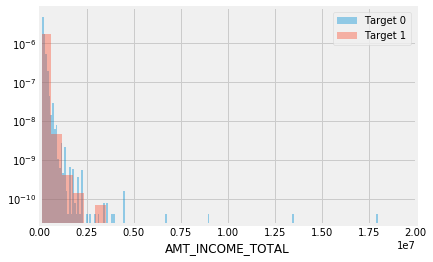

           TARGET_0      TARGET_1
count  2.826860e+05  2.482500e+04
mean   1.690496e+05  1.656020e+05
std    1.104409e+05  7.466609e+05
min    2.565000e+04  2.565000e+04
25%    1.125000e+05  1.125000e+05
50%    1.485000e+05  1.350000e+05
75%    2.025000e+05  2.025000e+05
max    1.800009e+07  1.170000e+08


In [27]:
# AMT_INCOME_TOTAL: income of the client
var_names = var_float.columns
var_n = var_names[0]
print('Float variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n]) * 100)

# distribution of variable:
A = train.loc[train['TARGET'] == 0, var_n]
B = train.loc[train['TARGET'] == 1, var_n]
var = (var_float.groupby([train['TARGET']])[var_n].value_counts(normalize=True)
       .rename('percentage').mul(100).reset_index().sort_values(var_n))
plt.rcParams['figure.figsize'] = 6,4
sns.distplot(A, bins=200, hist=True, kde=False, norm_hist=True, label='Target 0')
sns.distplot(B, bins=200, hist=True, kde=False, norm_hist=True, label='Target 1')
plt.yscale('log')
plt.xlim(0, 20000000)
plt.legend(loc='upper right')
plt.show()
# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('TARGET_0')
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('TARGET_1')
print(pd.concat([target_0_des, target_1_des], axis=1))


When seen on log scale we can see the difference in values for Target 0 and 1. kde plot is not used here as the values were much discrete. The kde plot was not realistic. While this seems to be the most important parameter in repaying loan, it does not reflect so. 

## Variable: AMT_CREDIT- Credit amount of the loan

Float variable name: AMT_CREDIT
% missing value 0.0


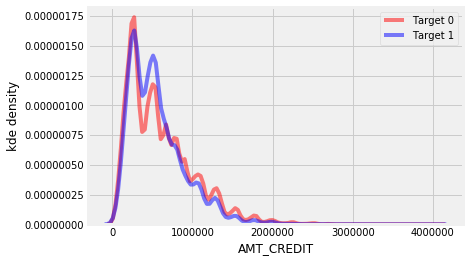

,TARGET_0,TARGET_1
count,282686.000,2.482500e+04
mean,602477.375,5.577772e+05
std,406810.000,3.464308e+05
min,45000.000,4.500000e+04
25%,270000.000,2.844000e+05
50%,517788.000,4.975200e+05
75%,810000.000,7.333155e+05
max,4050000.000,4.027680e+06


In [28]:
# AMT_CREDIT: Credit amount of the loan
var_names = var_float.columns
var = var_names[1]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var]))
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: AMT_ANNUITY- Loan annuity

Float variable name: AMT_ANNUITY
% missing value 0.003902299429939092


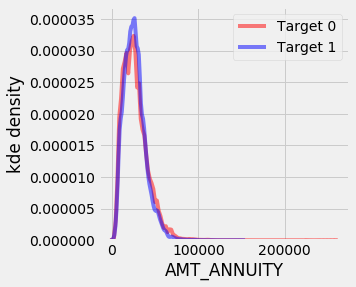

% missing value 0.0


,AMT_ANNUITY_TARGET_0,AMT_ANNUITY_TARGET_1
count,282686.000000,24825.000000
mean,27165.800781,26481.687500
std,14657.223633,12450.640625
min,1615.500000,2722.500000
25%,16456.500000,17361.000000
50%,24876.000000,25263.000000
75%,34749.000000,32976.000000
max,258025.500000,149211.000000


In [15]:
# AMT_ANNUITY: Loan annuity
var_names = var_float.columns
var = var_names[2]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values replace
var = 'AMT_ANNUITY'
train[var] = train[var].fillna(train[var].median())
test[var] = test[var].fillna(train[var].median())
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('AMT_ANNUITY_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('AMT_ANNUITY_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

AMT_ANNUITY represents amount of payments made at equal intervals. We will replace the missing values with median of the dataset.

## Variable: AMT_GOODS_PRICE- price of the goods for which the loan is given

Float variable name: AMT_GOODS_PRICE
% missing value 0.09040327012692229


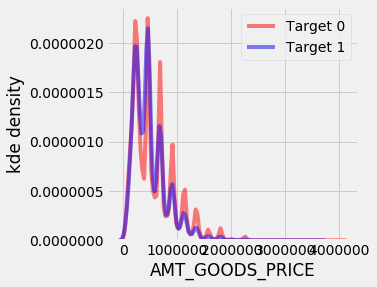

NameError: name 'Test' is not defined

In [16]:
# AMT_GOODS_PRICE: For consumer loans it is the price of the goods for which the loan is given
var_names = var_float.columns
var = var_names[3]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# replacing missing values 
train[var] = train[var].fillna(train[var].median())
test[var] = Test[var].fillna(train[var].median())

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('AMT_GOODS_PRICE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('AMT_GOODS_PRICE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

For consumer loans it is the price of the goods for which the loan is given. The missing values would be replaced with median.


## Variable: REGION_POPULATION_RELATIVE- Normalized population of region

Float variable name: REGION_POPULATION_RELATIVE
% missing value 0.0


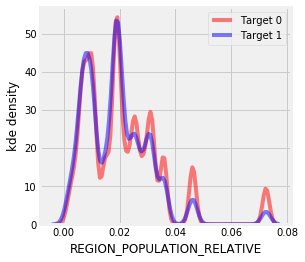

,REGION_POPULATION_RELATIVE_TARGET_0,REGION_POPULATION_RELATIVE_TARGET_1
count,282686.000000,24825.000000
mean,0.021019,0.019132
std,0.013977,0.011904
min,0.000290,0.000533
25%,0.010006,0.009630
50%,0.018850,0.018634
75%,0.028663,0.025164
max,0.072508,0.072508


In [36]:
# REGION_POPULATION_RELATIVE: Normalized population of region where client lives (higher number - more populated region)
var_names = var_float.columns
var = var_names[4]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('REGION_POPULATION_RELATIVE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('REGION_POPULATION_RELATIVE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: DAYS_REGISTRATION - 

Float variable name: DAYS_REGISTRATION
% missing value 0.0


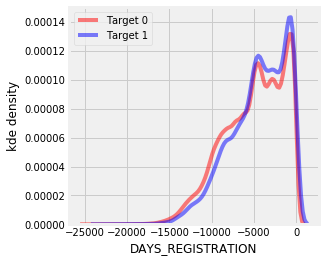

,DAYS_REGISTRATION_TARGET_0,DAYS_REGISTRATION_TARGET_1
count,282686.000000,24825.000000
mean,-5029.880371,-4487.119141
std,3538.336426,3299.649902
min,-24672.000000,-22928.000000
25%,-7550.000000,-6646.000000
50%,-4544.000000,-4056.000000
75%,-2045.000000,-1671.000000
max,0.000000,0.000000


In [43]:
#DAYS_REGISTRATION: How many days before the application did client change his registration
var_names = var_float.columns
var = var_names[5]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('DAYS_REGISTRATION_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('DAYS_REGISTRATION_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: OWN_CAR_AGE- Age of client's car

Float variable name: OWN_CAR_AGE
% missing value 65.9908100848425


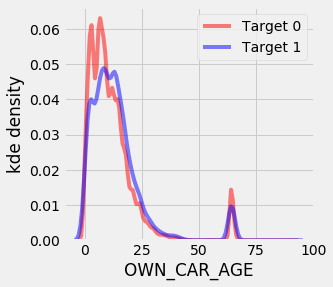

,OWN_CAR_AGE_TARGET_0,OWN_CAR_AGE_TARGET_1
count,282686.000000,24825.000000
mean,4.095778,4.171360
std,8.976245,9.342472
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,5.000000,4.000000
max,91.000000,91.000000


In [17]:
# OWN_CAR_AGE: Age of client's car
var_names = var_float.columns
var = var_names[6]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# dealing with missing value
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('OWN_CAR_AGE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('OWN_CAR_AGE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

This variable has 66% missing data. However the distribution looks similar for target 1 and 0. It probably does not affect the outcome but we will keep it. I won't make assumption about the car's age, as the nan values probably means that the applicant doesn't have a car. So I will replace the nan value with 0.

## Variable: CNT_FAM_MEMBERS - Count of family members

Float variable name: CNT_FAM_MEMBERS
% missing value 0.0006503832383231819


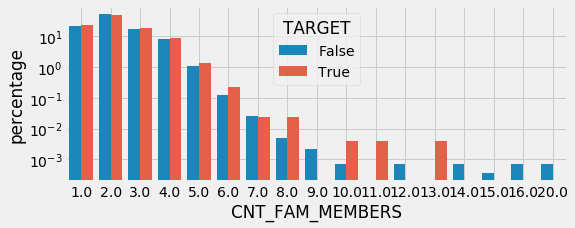


Group summary
     TARGET  CNT_FAM_MEMBERS  percentage
1    False              1.0   21.993463
16    True              1.0   22.860020
0    False              2.0   51.770882
15    True              2.0   48.374622
2    False              3.0   16.977615
17    True              3.0   18.561934
3    False              4.0    7.980996
18    True              4.0    8.604230
4    False              5.0    1.114672
19    True              5.0    1.317221
20    True              6.0    0.221551
5    False              6.0    0.124874
21    True              7.0    0.024169
6    False              7.0    0.026531
22    True              8.0    0.024169
7    False              8.0    0.004953
8    False              9.0    0.002123
23    True             10.0    0.004028
9    False             10.0    0.000708
24    True             11.0    0.004028
10   False             12.0    0.000708
25    True             13.0    0.004028
11   False             14.0    0.000708
14   False             1

In [18]:
# count of family members
var_names = var_float.columns
var = var_names[7]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
var_n = (var_float.groupby([train['TARGET']])[var_names[7]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[7]))
plt.rcParams['figure.figsize'] = 8,3
sns.barplot(x='CNT_FAM_MEMBERS', y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values
train[var] = train[var].fillna(train[var].median())
test[var] = test[var].fillna(train[var].median())

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('CNT_FAM_MEMBERS_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('CNT_FAM_MEMBERS_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)
print('\nGroup summary\n', var_n)

## Variable: EXT_SOURCE_1- Normalized score from external data source

Float variable name: EXT_SOURCE_1
% missing value 56.381072546998325


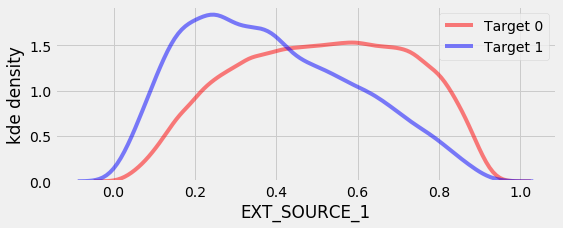

,EXT_SOURCE_1_TARGET_0,EXT_SOURCE_1_TARGET_1
count,282686.000000,24825.000000
mean,-0.336575,-0.438285
std,0.762213,0.693186
min,-1.000000,-1.000000
25%,-1.000000,-1.000000
50%,-1.000000,-1.000000
75%,0.471013,0.293274
max,0.962693,0.929394


In [19]:
# EXT_SOURCE_1- Normalized score from external data source
var_names = var_float.columns
var = var_names[8]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(-1)
test[var] = test[var].fillna(-1)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('EXT_SOURCE_1_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('EXT_SOURCE_1_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

This variable has 56% missing value and as can be seen is important to differentiate between Target 1 and target 0. May be data with nan are simply having no exetrnal source data. So we replace them with 0.

## Variable: EXT_SOURCE_2

Float variable name: EXT_SOURCE_2
% missing value 0.21462646864665005


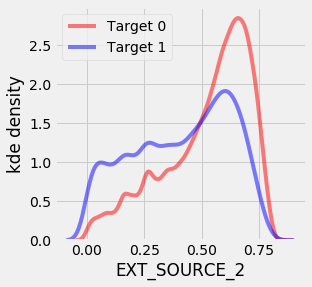

,EXT_SOURCE_2_TARGET_0,EXT_SOURCE_2_TARGET_1
count,282686.000000,24825.000000
mean,0.520209,0.407978
std,0.199006,0.222443
min,-1.000000,-1.000000
25%,0.408242,0.236789
50%,0.573402,0.439492
75%,0.667521,0.593937
max,0.855000,0.811870


In [20]:
var_names = var_float.columns
var = var_names[9]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing value dealing
train[var] = train[var].fillna(-1)
test[var] = test[var].fillna(-1)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('EXT_SOURCE_2_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('EXT_SOURCE_2_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Similar to previous one we will replace nan with -1.

## Variable: EXT_SOURCE_3

Float variable name: EXT_SOURCE_3
% missing value 19.825307062186393


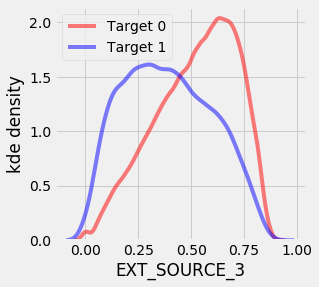

,EXT_SOURCE_3_TARGET_0,EXT_SOURCE_3_TARGET_1
count,282686.000000,24825.000000
mean,0.223497,0.072686
std,0.627130,0.611428
min,-1.000000,-1.000000
25%,0.199771,0.055711
50%,0.474051,0.288130
75%,0.643026,0.495666
max,0.893976,0.896010


In [21]:
# EXT_SOURCE_3
var_names = var_float.columns
var = var_names[10]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
plt.rcParams['figure.figsize'] = 4,4
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.show()

# missing values
train[var] = train[var].fillna(-1)
test[var] = test[var].fillna(-1)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('EXT_SOURCE_3_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('EXT_SOURCE_3_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

This important variable has 20% missing values. Similar to other external source we will replace nan with -1

## Variable: APARTMENTS_AVG- Normalized information about building

Float variable name: APARTMENTS_AVG
% missing value 50.74972927797705


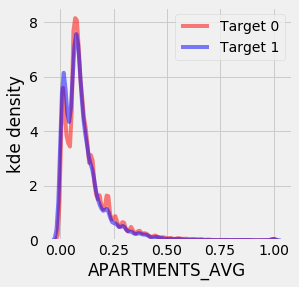

NameError: name 'tes' is not defined

In [22]:
# APARTMENTS_AVG: Normalized information about building where the client lives
var_names = var_float.columns
var = var_names[11]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

## missing values
train[var] = train[var].fillna(0)
tes[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('APARTMENTS_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('APARTMENTS_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

This variable has more than 50% values missing. The distribution looks similar for both targets. The missing values in this will be replaced 0 as nan may imply that the applicant did not have an apartment

## Variable: BASEMENTAREA_AVG: normalized information

Float variable name: BASEMENTAREA_AVG
% missing value 58.51595552679416


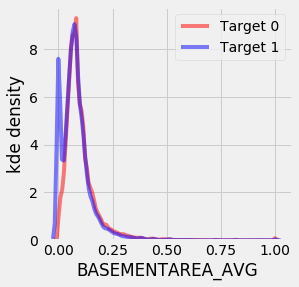

,BASEMENTAREA_AVG_TARGET_0,BASEMENTAREA_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.037377,0.028865
std,0.069394,0.058936
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.064500,0.046700
max,1.000000,1.000000


In [23]:
# BASEMENTAREA_AVG: normalized information
var_names = var_float.columns
var = var_names[12]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('BASEMENTAREA_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('BASEMENTAREA_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

More than 58% data are missing which would be replaced by 0 as before. For all building related information we will do the same.

## Variable: YEARS_BEGINEXPLUATATION_AVG: Normalized information about building 

Float variable name: YEARS_BEGINEXPLUATATION_AVG
% missing value 48.781019215572776


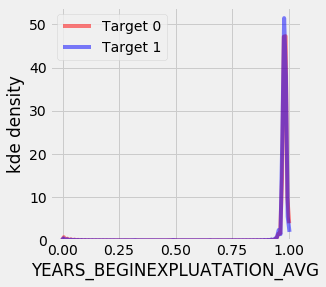

,YEARS_BEGINEXPLUATATION_AVG_TARGET_0,YEARS_BEGINEXPLUATATION_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.506767,0.432972
std,0.490573,0.486931
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.964200,0.000000
75%,0.982100,0.980100
max,1.000000,1.000000


In [24]:
# YEARS_BEGINEXPLUATATION_AVG: Normalized information about building where the client lives
var_names = var_float.columns
var = var_names[13]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('YEARS_BEGINEXPLUATATION_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('YEARS_BEGINEXPLUATATION_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## variable: YEARS_BUILD_AVG

Float variable name: YEARS_BUILD_AVG
% missing value 66.49778381911543


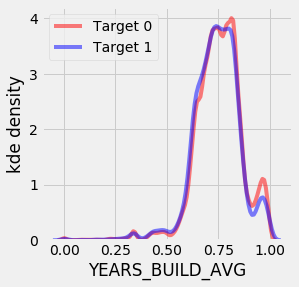

,YEARS_BUILD_AVG_TARGET_0,YEARS_BUILD_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.255634,0.211787
std,0.362458,0.340820
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.694000,0.632800
max,1.000000,1.000000


In [25]:
#YEARS_BUILD_AVG
var_names = var_float.columns
var = var_names[14]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('YEARS_BUILD_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('YEARS_BUILD_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: COMMONAREA_AVG

Float variable name: COMMONAREA_AVG
% missing value 69.87229725115525


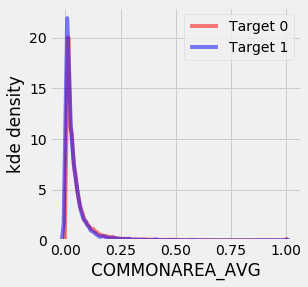

,COMMONAREA_AVG_TARGET_0,COMMONAREA_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.013731,0.010172
std,0.047112,0.038016
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.004600,0.000000
max,1.000000,1.000000


In [26]:
# COMMONAREA_AVG
var_names = var_float.columns
var = var_names[15]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('COMMONAREA_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('COMMONAREA_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: ELEVATORS_AVG

Float variable name: ELEVATORS_AVG
% missing value 53.29597965601231


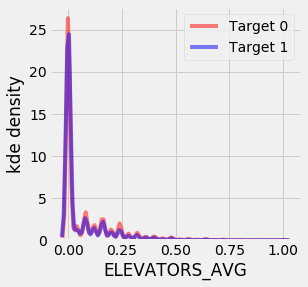

,ELEVATORS_AVG_TARGET_0,ELEVATORS_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.037943,0.024764
std,0.101544,0.081160
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [27]:
# ELEVATORS_AVG
var_names = var_float.columns
var = var_names[16]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
#train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('ELEVATORS_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('ELEVATORS_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: ENTRANCES_AVG

Float variable name: ENTRANCES_AVG
% missing value 50.3487680115508


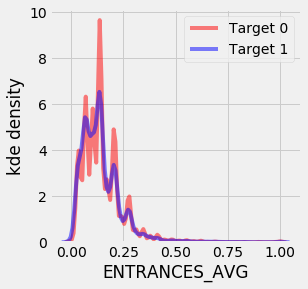

,ENTRANCES_AVG_TARGET_0,ENTRANCES_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.075536,0.061014
std,0.103310,0.095403
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.034500,0.000000
75%,0.137900,0.103400
max,1.000000,1.000000


In [28]:
# ENTRANCES_AVG
var_names = var_float.columns
var = var_names[17]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('ENTRANCES_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('ENTRANCES_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: FLOORSMAX_AVG

Float variable name: FLOORSMAX_AVG
% missing value 49.76082156410665


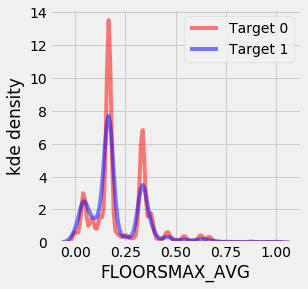

,FLOORSMAX_AVG_TARGET_0,FLOORSMAX_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.115903,0.088007
std,0.154138,0.134003
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.166700,0.166700
max,1.000000,1.000000


In [29]:
# FLOORSMAX_AVG
var_names = var_float.columns
var = var_names[18]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('FLOORSMAX_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('FLOORSMAX_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: FLOORSMIN_AVG

Float variable name: FLOORSMIN_AVG
% missing value 67.84862980511267


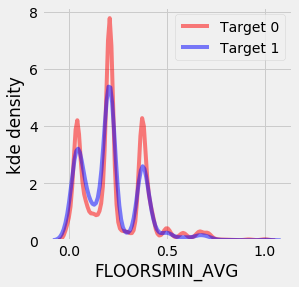

,FLOORSMIN_AVG_TARGET_0,FLOORSMIN_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.075996,0.058204
std,0.143381,0.122568
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.083300,0.041700
max,1.000000,1.000000


In [30]:
# FLOORSMIN_AVG
var_names = var_float.columns
var = var_names[19]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('FLOORSMIN_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('FLOORSMIN_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: LANDAREA_AVG

Float variable name: LANDAREA_AVG
% missing value 59.376737742714894


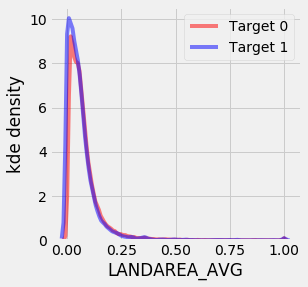

,LANDAREA_AVG_TARGET_0,LANDAREA_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.027366,0.022170
std,0.061480,0.056627
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.034900,0.021400
max,1.000000,1.000000


In [31]:
#LANDAREA_AVG
var_names = var_float.columns
var = var_names[20]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('LANDAREA_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('LANDAREA_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: LIVINGAPARTMENTS_AVG

Float variable name: LIVINGAPARTMENTS_AVG
% missing value 68.35495315614726


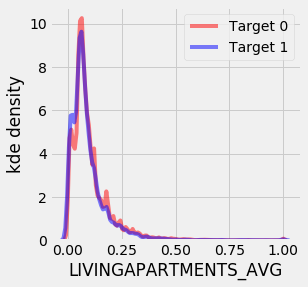

,LIVINGAPARTMENTS_AVG_TARGET_0,LIVINGAPARTMENTS_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.032503,0.024910
std,0.070783,0.061191
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.047100,0.012600
max,1.000000,1.000000


In [32]:
# LIVINGAPARTMENTS_AVG
var_names = var_float.columns
var = var_names[21]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('LIVINGAPARTMENTS_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('LIVINGAPARTMENTS_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: LIVINGAREA_AVG

Float variable name: LIVINGAREA_AVG
% missing value 50.193326417591564


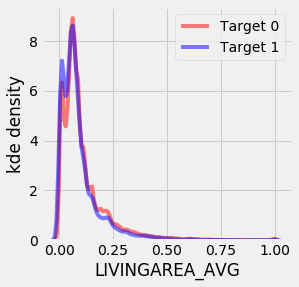

,LIVINGAREA_AVG_TARGET_0,LIVINGAREA_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.054623,0.040610
std,0.095679,0.080852
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.001900,0.000000
75%,0.075800,0.058700
max,1.000000,1.000000


In [33]:
# LIVINGAREA_AVG
var_names = var_float.columns
var = var_names[22]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('LIVINGAREA_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('LIVINGAREA_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: NONLIVINGAPARTMENTS_AVG

Float variable name: NONLIVINGAPARTMENTS_AVG
% missing value 69.43296337366793


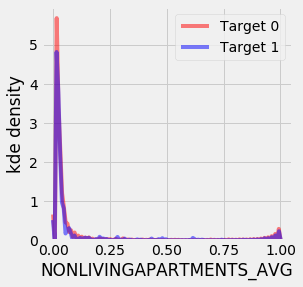

,NONLIVINGAPARTMENTS_AVG_TARGET_0,NONLIVINGAPARTMENTS_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.002739,0.002160
std,0.026869,0.024127
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [34]:
# NONLIVINGAPARTMENTS_AVG
var_names = var_float.columns
var = var_names[23]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.xscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('NONLIVINGAPARTMENTS_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('NONLIVINGAPARTMENTS_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: NONLIVINGAREA_AVG

Float variable name: NONLIVINGAREA_AVG
% missing value 55.17916432257708


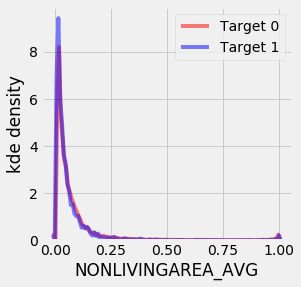

,NONLIVINGAREA_AVG_TARGET_0,NONLIVINGAREA_AVG_TARGET_1
count,282686.000000,24825.000000
mean,0.012990,0.009519
std,0.049342,0.040430
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.001300,0.000000
max,1.000000,1.000000


In [35]:
# NONLIVINGAREA_AVG
var_names = var_float.columns
var = var_names[24]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('NONLIVINGAREA_AVG_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('NONLIVINGAREA_AVG_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: APARTMENTS_MODE

Float variable name: APARTMENTS_MODE
% missing value 50.74972927797705


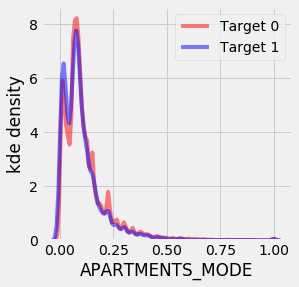

,APARTMENTS_MODE_TARGET_0,APARTMENTS_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.057349,0.043927
std,0.095667,0.083478
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.084000,0.069300
max,1.000000,1.000000


In [36]:
# APARTMENTS_MODE
var_names = var_float.columns
var = var_names[25]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('APARTMENTS_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('APARTMENTS_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: BASEMENTAREA_MODE

Float variable name: BASEMENTAREA_MODE
% missing value 58.51595552679416


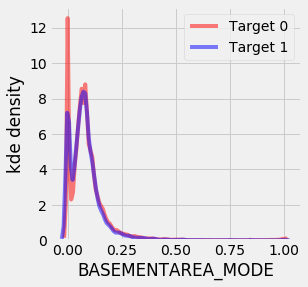

,BASEMENTAREA_MODE_TARGET_0,BASEMENTAREA_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.036977,0.028798
std,0.070025,0.059745
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.063400,0.044300
max,1.000000,1.000000


In [37]:
# BASEMENTAREA_MODE
var_names = var_float.columns
var = var_names[26]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('BASEMENTAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('BASEMENTAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: YEARS_BEGINEXPLUATATION_MODE

Float variable name: YEARS_BEGINEXPLUATATION_MODE
% missing value 48.781019215572776


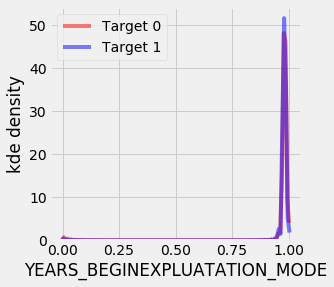

,YEARS_BEGINEXPLUATATION_MODE_TARGET_0,YEARS_BEGINEXPLUATATION_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.506416,0.432662
std,0.490753,0.486869
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.963300,0.000000
75%,0.982100,0.979600
max,1.000000,1.000000


In [38]:
# YEARS_BEGINEXPLUATATION_MODE
var_names = var_float.columns
var = var_names[27]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('YEARS_BEGINEXPLUATATION_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('YEARS_BEGINEXPLUATATION_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: YEARS_BUILD_MODE

Float variable name: YEARS_BUILD_MODE
% missing value 66.49778381911543


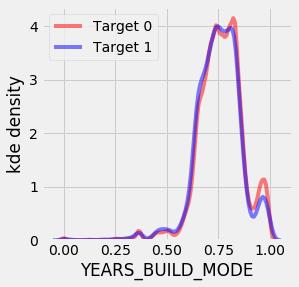

,YEARS_BUILD_MODE_TARGET_0,YEARS_BUILD_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.258048,0.213911
std,0.365548,0.343821
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.699400,0.647200
max,1.000000,1.000000


In [39]:
# YEARS_BUILD_MODE
var_names = var_float.columns
var = var_names[28]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('YEARS_BUILD_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('YEARS_BUILD_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: COMMONAREA_MODE

Float variable name: COMMONAREA_MODE
% missing value 69.87229725115525


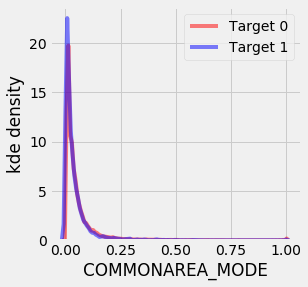

,COMMONAREA_MODE_TARGET_0,COMMONAREA_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.013084,0.009822
std,0.045939,0.037553
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.003700,0.000000
max,1.000000,1.000000


In [40]:
# COMMONAREA_MODE
var_names = var_float.columns
var = var_names[29]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('COMMONAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('COMMONAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: ELEVATORS_MODE

Float variable name: ELEVATORS_MODE
% missing value 53.29597965601231


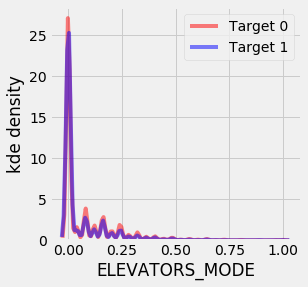

,COMMONAREA_MODE_TARGET_0,COMMONAREA_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.035785,0.023505
std,0.098928,0.079727
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [41]:
var_names = var_float.columns
var = var_names[30]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('COMMONAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('COMMONAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: ENTRANCES_MODE

Float variable name: ENTRANCES_MODE
% missing value 50.3487680115508


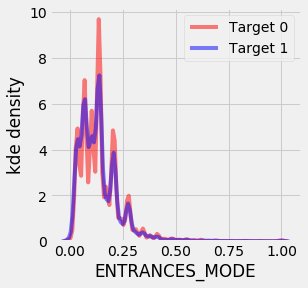

,ENTRANCES_MODE_TARGET_0,ENTRANCES_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.073236,0.059330
std,0.102173,0.094367
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.034500,0.000000
75%,0.137900,0.103400
max,1.000000,1.000000


In [42]:
var_names = var_float.columns
var = var_names[31]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('ENTRANCES_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('ENTRANCES_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: FLOORSMAX_MODE

Float variable name: FLOORSMAX_MODE
% missing value 49.76082156410665


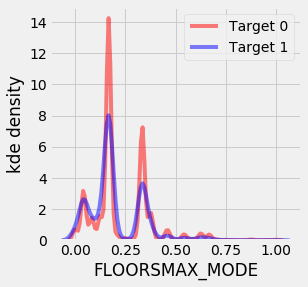

,FLOORSMAX_MODE_TARGET_0,FLOORSMAX_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.113864,0.086529
std,0.152239,0.132342
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.166700,0.166700
max,1.000000,1.000000


In [43]:
var_names = var_float.columns
var = var_names[32]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('FLOORSMAX_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('FLOORSMAX_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: FLOORSMIN_MODE

Float variable name: FLOORSMIN_MODE
% missing value 67.84862980511267


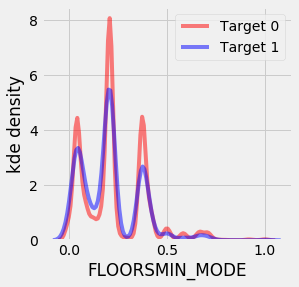

,FLOORSMIN_MODE_TARGET_0,FLOORSMIN_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.074734,0.057308
std,0.141709,0.121367
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.083300,0.041700
max,1.000000,1.000000


In [44]:
var_names = var_float.columns
var = var_names[33]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('FLOORSMIN_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('FLOORSMIN_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: LANDAREA_MODE

Float variable name: LANDAREA_MODE
% missing value 59.376737742714894


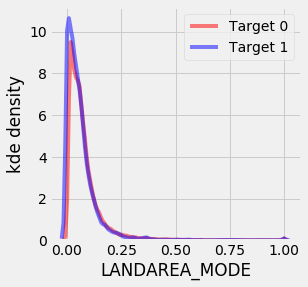

,LANDAREA_MODE_TARGET_0,LANDAREA_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.026795,0.021753
std,0.061530,0.056389
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.032300,0.019600
max,1.000000,1.000000


In [45]:
var_names = var_float.columns
var = var_names[34]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('LANDAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('LANDAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: LIVINGAPARTMENTS_MODE

Float variable name: LIVINGAPARTMENTS_MODE
% missing value 68.35495315614726


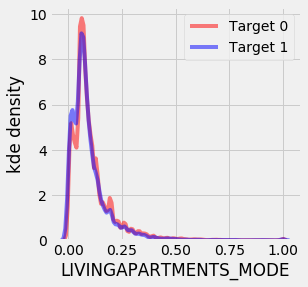

,LIVINGAPARTMENTS_MODE_TARGET_0,LIVINGAPARTMENTS_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.034063,0.026252
std,0.074587,0.064898
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.049600,0.011000
max,1.000000,1.000000


In [46]:
var_names = var_float.columns
var = var_names[35]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('LIVINGAPARTMENTS_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('LIVINGAPARTMENTS_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: LIVINGAREA_MODE

Float variable name: LIVINGAREA_MODE
% missing value 50.193326417591564


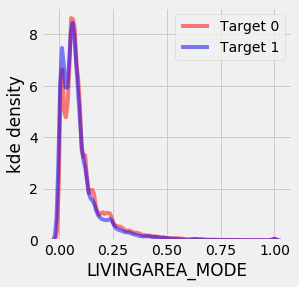

,LIVINGAREA_MODE_TARGET_0,LIVINGAREA_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.053876,0.040336
std,0.096138,0.081601
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.001600,0.000000
75%,0.073700,0.056800
max,1.000000,1.000000


In [47]:
var_names = var_float.columns
var = var_names[36]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('LIVINGAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('LIVINGAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: NONLIVINGAPARTMENTS_MODE

Float variable name: NONLIVINGAPARTMENTS_MODE
% missing value 69.43296337366793


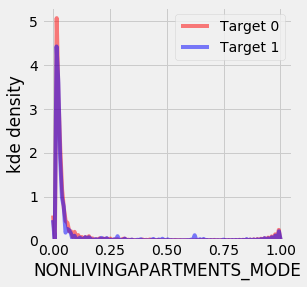

,NONLIVINGAPARTMENTS_MODE_TARGET_0,NONLIVINGAPARTMENTS_MODE_TARGET_1
count,282686.000000,24825.000000
mean,0.002506,0.002045
std,0.025976,0.024097
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [48]:
var_names = var_float.columns
var = var_names[37]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('NONLIVINGAPARTMENTS_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('NONLIVINGAPARTMENTS_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)


## Variable: NONLIVINGAREA_MODE

Float variable name: NONLIVINGAREA_MODE
% missing value 55.17916432257708


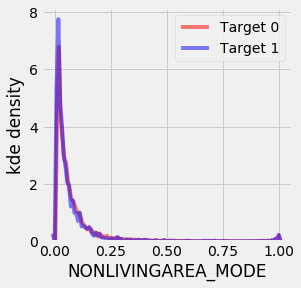

,NONLIVINGAREA_MODE_TARGET_0,NONLIVINGAREA_MODE_TARGET_1
count,282686.000000,24825.00000
mean,0.012378,0.00908
std,0.049613,0.04077
min,0.000000,0.00000
25%,0.000000,0.00000
50%,0.000000,0.00000
75%,0.000000,0.00000
max,1.000000,1.00000


In [49]:
var_names = var_float.columns
var = var_names[38]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('NONLIVINGAREA_MODE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('NONLIVINGAREA_MODE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: APARTMENTS_MEDI

Float variable name: APARTMENTS_MEDI
% missing value 50.74972927797705


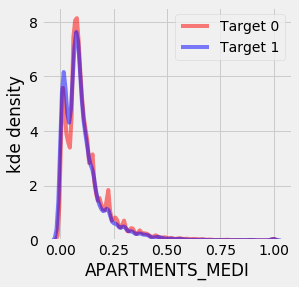

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.059173,0.045094
std,0.097487,0.084442
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.087400,0.072900
max,1.000000,1.000000


In [50]:
var_names = var_float.columns
var = var_names[39]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: BASEMENTAREA_MEDI

Float variable name: BASEMENTAREA_MEDI
% missing value 58.51595552679416


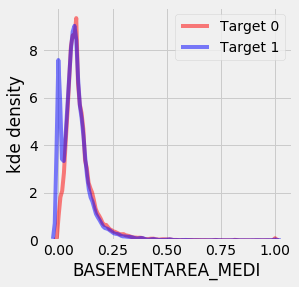

,BASEMENTAREA_MEDI_TARGET_0,BASEMENTAREA_MEDI_TARGET_1
count,282686.000000,24825.000000
mean,0.037165,0.028771
std,0.069130,0.058895
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.064000,0.046400
max,1.000000,1.000000


In [51]:
var_names = var_float.columns
var = var_names[40]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('BASEMENTAREA_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('BASEMENTAREA_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: 

Float train name: YEARS_BEGINEXPLUATATION_MEDI
% missing value 48.781019215572776


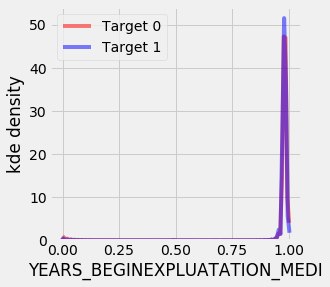

,YEARS_BEGINEXPLUATATION_MEDI_TARGET_0,YEARS_BEGINEXPLUATATION_MEDI_TARGET_1
count,282686.000000,24825.000000
mean,0.506778,0.432944
std,0.490618,0.486977
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.964200,0.000000
75%,0.982100,0.979600
max,1.000000,1.000000


In [52]:
var_names = var_float.columns
var = var_names[41]
print('Float train name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of train:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.xscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('YEARS_BEGINEXPLUATATION_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('YEARS_BEGINEXPLUATATION_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: YEARS_BUILD_MEDI

Float variable name: YEARS_BUILD_MEDI
% missing value 66.49778381911543


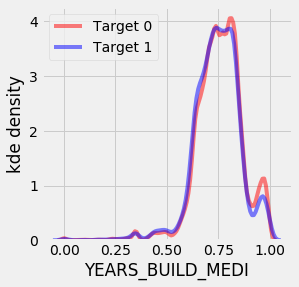

,YEARS_BUILD_MEDI_TARGET_0,YEARS_BUILD_MEDI_TARGET_1
count,282686.000000,24825.000000
mean,0.256744,0.212727
std,0.364248,0.342155
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.698100,0.637700
max,1.000000,1.000000


In [53]:
var_names = var_float.columns
var = var_names[42]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('YEARS_BUILD_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('YEARS_BUILD_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: COMMONAREA_MEDI

Float variable name: COMMONAREA_MEDI
% missing value 69.87229725115525


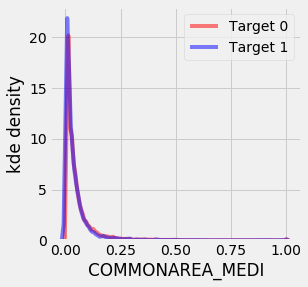

,COMMONAREA_MEDI_TARGET_0,COMMONAREA_MEDI_TARGET_1
count,282686.000000,24825.000000
mean,0.013723,0.010162
std,0.047163,0.038054
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.004500,0.000000
max,1.000000,1.000000


In [54]:
var_names = var_float.columns
var = var_names[43]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('COMMONAREA_MEDI_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('COMMONAREA_MEDI_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: ELEVATORS_MEDI

Float variable name: ELEVATORS_MEDI
% missing value 53.29597965601231


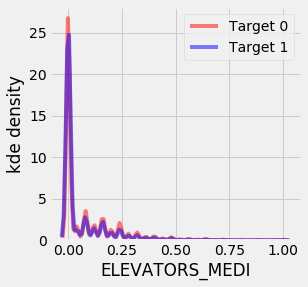

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.037529,0.024491
std,0.101368,0.080957
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [55]:
var_names = var_float.columns
var = var_names[44]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: ENTRANCES_MEDI

Float variable name: ENTRANCES_MEDI
% missing value 50.3487680115508


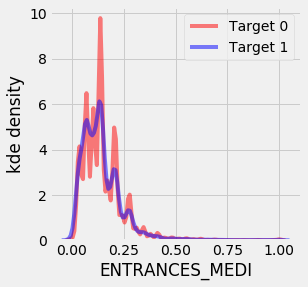

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.075278,0.060809
std,0.103252,0.095357
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.034500,0.000000
75%,0.137900,0.103400
max,1.000000,1.000000


In [56]:
var_names = var_float.columns
var = var_names[45]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: FLOORSMAX_MEDI

Float variable name: FLOORSMAX_MEDI
% missing value 49.76082156410665


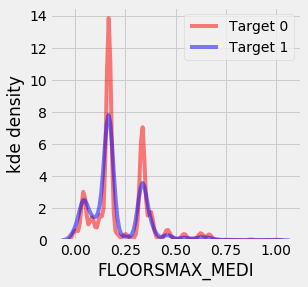

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.115705,0.087864
std,0.153937,0.134001
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.166700,0.166700
max,1.000000,1.000000


In [57]:
var_names = var_float.columns
var = var_names[46]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: FLOORSMIN_MEDI

Float variable name: FLOORSMIN_MEDI
% missing value 67.84862980511267


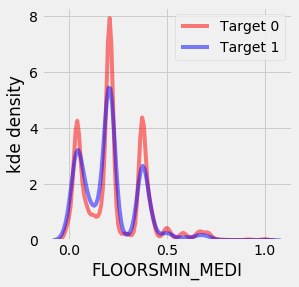

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.075908,0.058148
std,0.143514,0.122580
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.083300,0.041700
max,1.000000,1.000000


In [58]:
var_names = var_float.columns
var = var_names[47]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: LANDAREA_MEDI

Float variable name: LANDAREA_MEDI
% missing value 59.376737742714894


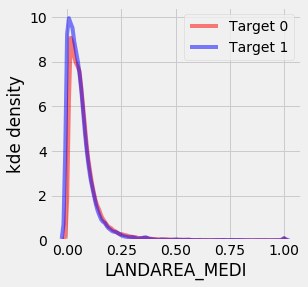

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.027714,0.022410
std,0.062334,0.056902
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.035100,0.021600
max,1.000000,1.000000


In [59]:
var_names = var_float.columns
var = var_names[48]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)


# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: LIVINGAPARTMENTS_MEDI

Float variable name: LIVINGAPARTMENTS_MEDI
% missing value 68.35495315614726


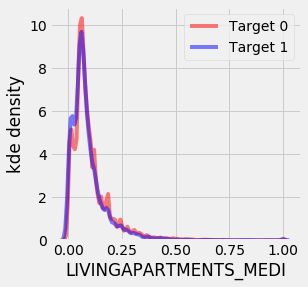

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.032880,0.025240
std,0.071611,0.062094
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.047900,0.012000
max,1.000000,1.000000


In [60]:
var_names = var_float.columns
var = var_names[49]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: LIVINGAREA_MEDI

Float variable name: LIVINGAREA_MEDI
% missing value 50.193326417591564


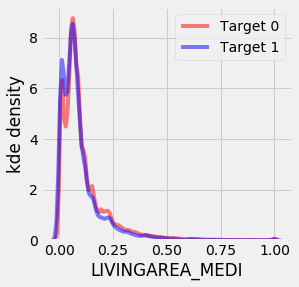

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.055236,0.041089
std,0.097036,0.081921
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.001900,0.000000
75%,0.076500,0.059300
max,1.000000,1.000000


In [61]:
var_names = var_float.columns
var = var_names[50]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: NONLIVINGAPARTMENTS_MEDI

Float variable name: NONLIVINGAPARTMENTS_MEDI
% missing value 69.43296337366793


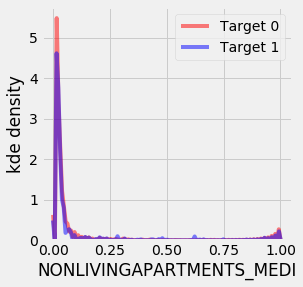

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.002689,0.002139
std,0.026672,0.024158
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [62]:
var_names = var_float.columns
var = var_names[51]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: NONLIVINGAREA_MEDI

Float variable name: NONLIVINGAREA_MEDI
% missing value 55.17916432257708


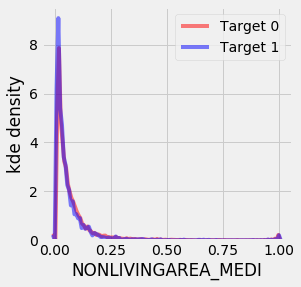

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.012934,0.009484
std,0.049662,0.040865
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000800,0.000000
max,1.000000,1.000000


In [63]:
var_names = var_float.columns
var = var_names[52]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: TOTALAREA_MODE

Float variable name: TOTALAREA_MODE
% missing value 48.26851722377411


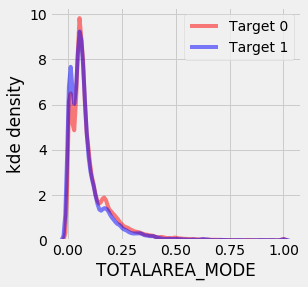

,TARGET_0,TARGET_1
count,282686.000000,24825.000000
mean,0.054176,0.040207
std,0.093698,0.079632
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.006400,0.000000
75%,0.071400,0.056000
max,1.000000,1.000000


In [64]:
var_names = var_float.columns
var = var_names[53]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

We see that house/lving description had maximum % of missing values

## Variable: OBS_30_CNT_SOCIAL_CIRCLE

Float variable name: OBS_30_CNT_SOCIAL_CIRCLE
% missing value 0.3320206431639844


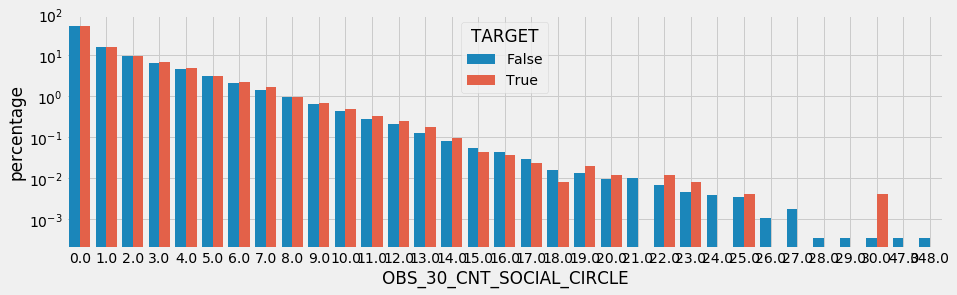

,OBS_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE
count,282686.000000,24825.000000
mean,1.410809,1.493978
std,2.400658,2.377478
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,2.000000
max,348.000000,30.000000


In [65]:
var_names = var_float.columns
var = var_names[54]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
A = train.loc[train['TARGET'] == 0, var]
B = train.loc[train['TARGET'] == 1, var]
var_n = (var_float.groupby([train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 14,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

This variable describes 'how many observation of client's social surroundings with observable 30 DPD (days past due) default'. We will replace nan with 0.


## Variable: DEF_30_CNT_SOCIAL_CIRCLE

Float variable name: DEF_30_CNT_SOCIAL_CIRCLE
% missing value 0.3320206431639844


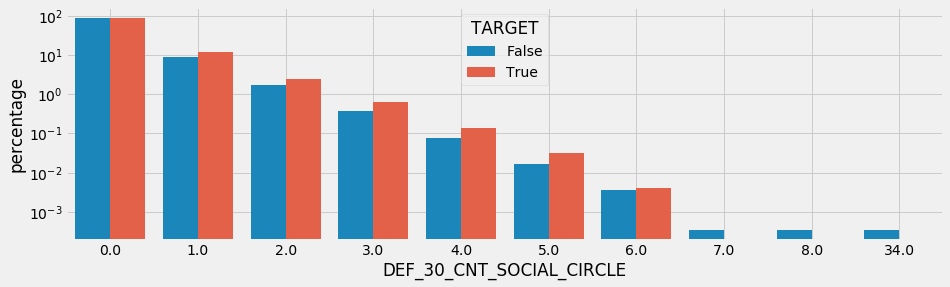

,DEF_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE
count,282686.000000,24825.000000
mean,0.138663,0.191702
std,0.439354,0.516186
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,34.000000,6.000000


In [66]:
var_names = var_float.columns
var = var_names[55]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
A = train.loc[train['TARGET'] == 0, var]
B = train.loc[train['TARGET'] == 1, var]
var_n = (var_float.groupby([train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 14,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: OBS_60_CNT_SOCIAL_CIRCLE

Float variable name: OBS_60_CNT_SOCIAL_CIRCLE
% missing value 0.3320206431639844


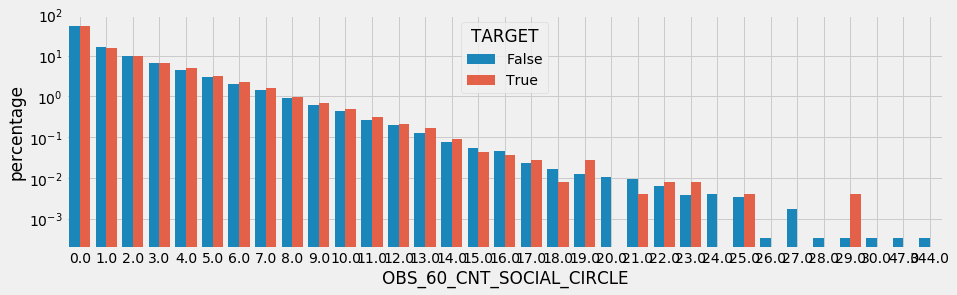

,OBS_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
count,282686.000000,24825.000000
mean,1.394049,1.475529
std,2.380630,2.354917
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,2.000000
max,344.000000,29.000000


In [67]:
var_names = var_float.columns
var = var_names[56]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
A = train.loc[train['TARGET'] == 0, var]
B = train.loc[train['TARGET'] == 1, var]
var_n = (var_float.groupby([train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 14,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: DEF_60_CNT_SOCIAL_CIRCLE

Float variable name: DEF_60_CNT_SOCIAL_CIRCLE
% missing value 0.3320206431639844


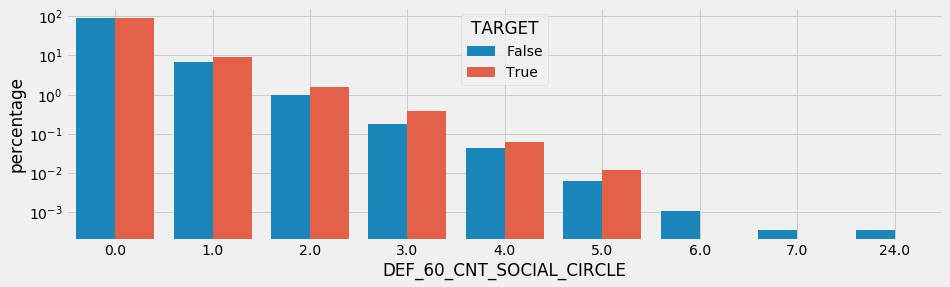

,DEF_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
count,282686.000000,24825.000000
mean,0.096351,0.138046
std,0.355436,0.427351
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,24.000000,5.000000


In [68]:
var_names = var_float.columns
var = var_names[57]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
A = train.loc[train['TARGET'] == 0, var]
B = train.loc[train['TARGET'] == 1, var]
var_n = (var_float.groupby([train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 14,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: DAYS_LAST_PHONE_CHANGE

Float variable name: DAYS_LAST_PHONE_CHANGE
% missing value 0.00032519161916159093


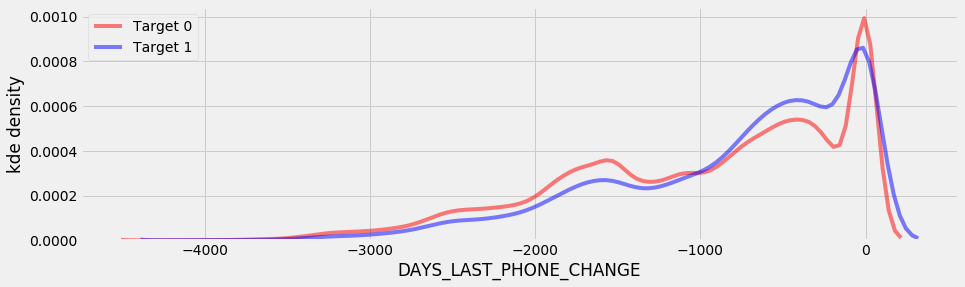

,DAYS_LAST_PHONE_CHANGE_TARGET_0,DAYS_LAST_PHONE_CHANGE_TARGET_1
count,282686.000000,24825.000000
mean,-976.332458,-808.799927
std,831.066711,758.102539
min,-4292.000000,-4070.000000
25%,-1586.000000,-1301.000000
50%,-776.000000,-594.000000
75%,-281.000000,-194.000000
max,0.000000,0.000000


In [69]:
var_names = var_float.columns
var = var_names[58]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# missing values #
train[var] = train[var].fillna(train[var].median())
test[var] = test[var].fillna(train[var].median())

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('DAYS_LAST_PHONE_CHANGE_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('DAYS_LAST_PHONE_CHANGE_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

This variable describes 'How many days before application did client change phone'. We will replace the missing values with median

## Variable: AMT_REQ_CREDIT_BUREAU_HOUR

Float variable name: AMT_REQ_CREDIT_BUREAU_HOUR
% missing value 13.501630835970097


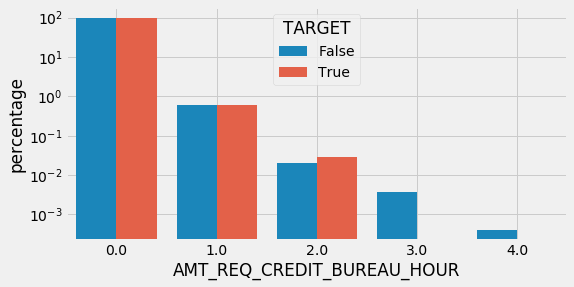

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_HOUR
count,282686.000000,24825.000000
mean,0.005540,0.005519
std,0.078045,0.077278
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,4.000000,2.000000


In [70]:
var_names = var_float.columns
var = var_names[59]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
A = train.loc[train['TARGET'] == 0, var]
B = train.loc[train['TARGET'] == 1, var]
var_n = (var_float.groupby([train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

Variable describes 'Number of enquiries to Credit Bureau about the client one hour before application'. We will replace the missing values with 0.

## Variable: AMT_REQ_CREDIT_BUREAU_DAY

Float variable name: AMT_REQ_CREDIT_BUREAU_DAY
% missing value 13.501630835970097


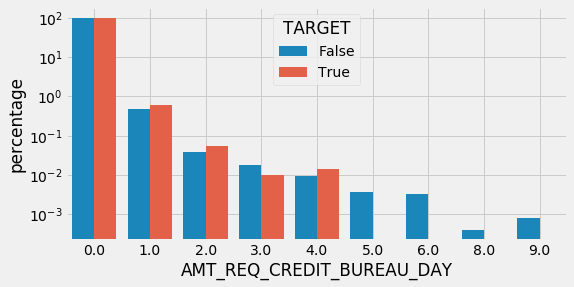

,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_DAY
count,282686.000000,24825.000000
mean,0.006003,0.006647
std,0.103453,0.097077
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,9.000000,4.000000


In [71]:
var_names = var_float.columns
var = var_names[60]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
A = train.loc[train['TARGET'] == 0, var]
B = train.loc[train['TARGET'] == 1, var]
var_n = (var_float.groupby([train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: AMT_REQ_CREDIT_BUREAU_WEEK

Float variable name: AMT_REQ_CREDIT_BUREAU_WEEK
% missing value 13.501630835970097


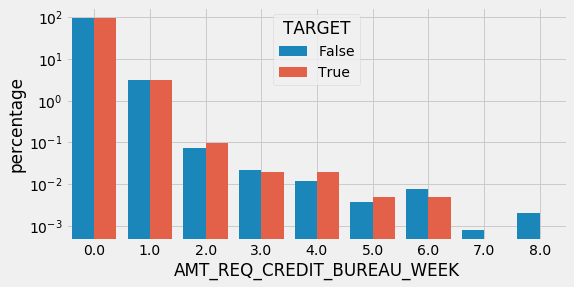

,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_WEEK
count,282686.000000,24825.000000
mean,0.029796,0.028882
std,0.191322,0.185958
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,8.000000,6.000000


In [72]:
var_names = var_float.columns
var = var_names[61]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
A = train.loc[train['TARGET'] == 0, var]
B = train.loc[train['TARGET'] == 1, var]
var_n = (var_float.groupby([train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: AMT_REQ_CREDIT_BUREAU_MON

Float variable name: AMT_REQ_CREDIT_BUREAU_MON
% missing value 13.501630835970097


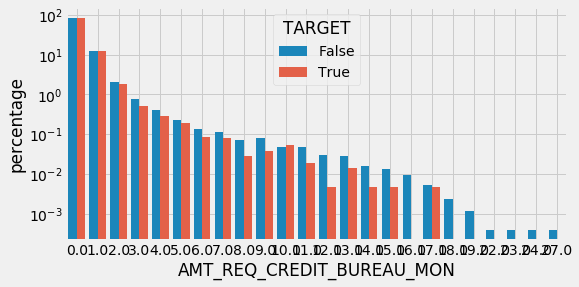

,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_MON
count,282686.000000,24825.000000
mean,0.235049,0.188520
std,0.871373,0.683087
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,27.000000,17.000000


In [73]:
var_names = var_float.columns
var = var_names[62]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
A = train.loc[train['TARGET'] == 0, var]
B = train.loc[train['TARGET'] == 1, var]
var_n = (var_float.groupby([train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: AMT_REQ_CREDIT_BUREAU_QRT

Float variable name: AMT_REQ_CREDIT_BUREAU_QRT
% missing value 13.501630835970097


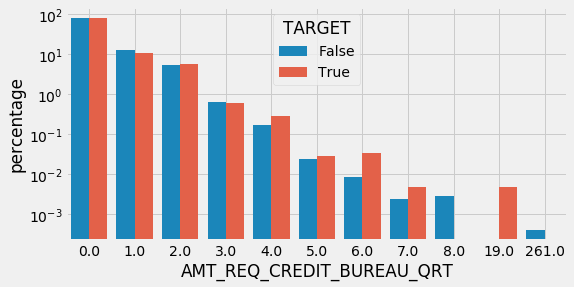

,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_QRT
count,282686.000000,24825.000000
mean,0.230917,0.214985
std,0.755301,0.593708
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,261.000000,19.000000


In [74]:
var_names = var_float.columns
var = var_names[63]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
A = train.loc[train['TARGET'] == 0, var]
B = train.loc[train['TARGET'] == 1, var]
var_n = (var_float.groupby([train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: AMT_REQ_CREDIT_BUREAU_YEAR

Float variable name: AMT_REQ_CREDIT_BUREAU_YEAR
% missing value 13.501630835970097


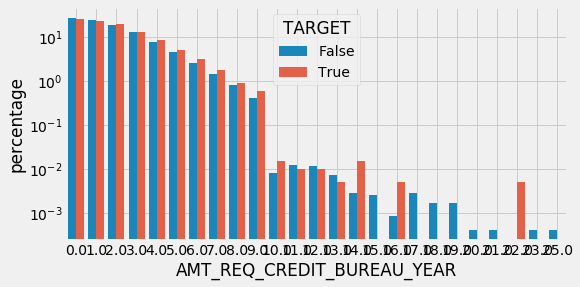

,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_YEAR
count,282686.000000,24825.000000
mean,1.640410,1.678026
std,1.850591,1.918949
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,3.000000,3.000000
max,25.000000,22.000000


In [75]:
var_names = var_float.columns
var = var_names[64]
print('Float variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)
# distribution of variable:
A = train.loc[train['TARGET'] == 0, var]
B = train.loc[train['TARGET'] == 1, var]
var_n = (var_float.groupby([train['TARGET']])[var].value_counts(normalize=True)
         .rename('percentage').mul(100).reset_index().sort_values(var))
plt.rcParams['figure.figsize'] = 8,4
sns.barplot(x=var, y='percentage', hue='TARGET', data=var_n)
plt.grid(True)
plt.yscale('log')
plt.show()

# missing values #train[var] = train[var].fillna(train[var].median())
train[var] = train[var].fillna(0)
test[var] = test[var].fillna(0)

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename(var)
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename(var)
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable type: Integer

In [166]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_names[0]

'TARGET'

## Variable: FLAG_MOBIL

Integer variable name: FLAG_MOBIL
% missing value 0.0


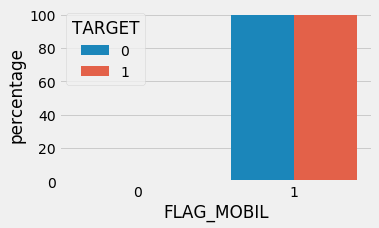

Group summary
    TARGET  FLAG_MOBIL  percentage
1       0           0    0.000354
0       0           1   99.999646
2       1           1  100.000000

Statistical summary:
        FLAG_MOBIL_TARGET_0 FLAG_MOBIL_TARGET_1
count               282686               24825
unique                   2                   1
top                   True                True
freq                282685               24825


In [76]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[1]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
var = (var_int_cnt.groupby([var_names[0]])[var_names[1]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[1]))
plt.rcParams['figure.figsize'] = 5,3
sns.barplot(x="FLAG_MOBIL", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_MOBIL_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_MOBIL_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_MOBIL'])
test = test.drop(columns=['FLAG_MOBIL'])

This variable describes if 'client provide mobile phone (1=YES, 0=NO)'.All data are flagged as 1. So we can get rid of this variable.

## Variable: FLAG_EMP_PHONE

Integer variable name: FLAG_EMP_PHONE
% missing value 0.0


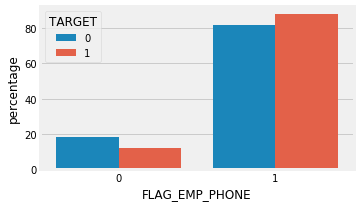

Group summary
    TARGET  FLAG_EMP_PHONE  percentage
1       0               0   18.534699
3       1               0   12.048338
0       0               1   81.465301
2       1               1   87.951662

Statistical summary:
        FLAG_EMP_PHONE_TARGET_0 FLAG_EMP_PHONE_TARGET_1
count                   282686                   24825
unique                       2                       2
top                       True                    True
freq                    230291                   21834


In [173]:
var_n = var_names[2]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[2]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[2]))
sns.barplot(x="FLAG_EMP_PHONE", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_EMP_PHONE_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_EMP_PHONE_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

Did client provide work phone (1=YES, 0=NO): we would replace nan with 0.

## Variable: FLAG_WORK_PHONE

Integer variable name: FLAG_WORK_PHONE
% missing value 0.0


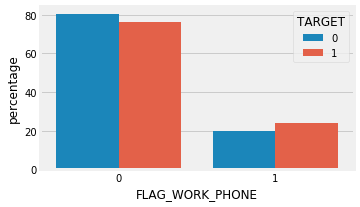

Group summary
    TARGET  FLAG_WORK_PHONE  percentage
0       0                0   80.400869
2       1                0   76.217523
1       0                1   19.599131
3       1                1   23.782477

Statistical summary:
        FLAG_WORK_PHONE_TARGET_0  FLAG_WORK_PHONE_TARGET_1
count             282686.000000              24825.000000
mean                   0.195991                  0.237825
std                    0.396963                  0.425760
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [177]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[3]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[3]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[3]))
sns.barplot(x="FLAG_WORK_PHONE", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_WORK_PHONE_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_WORK_PHONE_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

## Variable: FLAG_CONT_MOBILE

Integer variable name: FLAG_CONT_MOBILE
% missing value 0.0


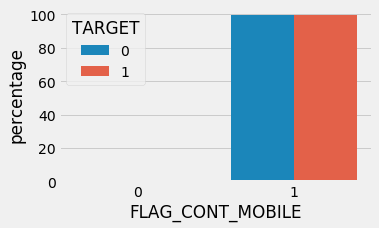

Group summary
    TARGET  FLAG_CONT_MOBILE  percentage
1       0                 0    0.187133
3       1                 0    0.181269
0       0                 1   99.812867
2       1                 1   99.818731

Statistical summary:
        FLAG_CONT_MOBILE_TARGET_0 FLAG_CONT_MOBILE_TARGET_1
count                     282686                     24825
unique                         2                         2
top                         True                      True
freq                      282157                     24780


In [77]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[4]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[4]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[4]))
sns.barplot(x="FLAG_CONT_MOBILE", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_CONT_MOBILE_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_CONT_MOBILE_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

train = train.drop(columns=['FLAG_CONT_MOBILE'])
test = test.drop(columns=['FLAG_CONT_MOBILE'])

This variable also does not make any difference. We will get rid of this variable.

## Variable: FLAG_PHONE

Integer variable name: FLAG_PHONE
% missing value 0.0


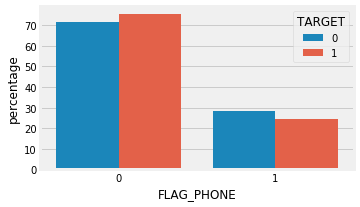

Group summary
    TARGET  FLAG_PHONE  percentage
0       0           0   71.576237
2       1           0   75.504532
1       0           1   28.423763
3       1           1   24.495468

Statistical summary:
        FLAG_PHONE_TARGET_0 FLAG_PHONE_TARGET_1
count               282686               24825
unique                   2                   2
top                  False               False
freq                202336               18744


In [180]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[5]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[5]].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(var_names[5]))
sns.barplot(x="FLAG_PHONE", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_PHONE_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_PHONE_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

## Variable: FLAG_EMAIL

Integer variable name: FLAG_EMAIL
% missing value 0.0


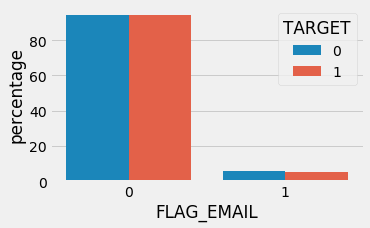

Group summary
    TARGET  FLAG_EMAIL  percentage
0       0           0   94.315955
2       1           0   94.465257
1       0           1    5.684045
3       1           1    5.534743

Statistical summary:
        FLAG_MOBIL_TARGET_0  FLAG_MOBIL_TARGET_1
count        282686.000000         24825.000000
mean              0.056840             0.055347
std               0.231538             0.228662
min               0.000000             0.000000
25%               0.000000             0.000000
50%               0.000000             0.000000
75%               0.000000             0.000000
max               1.000000             1.000000


In [78]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[6]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[6]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[6]))
sns.barplot(x="FLAG_EMAIL", y='percentage', hue='TARGET', data=var)
plt.show()

# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_MOBIL_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_MOBIL_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

train = train.drop(columns=['FLAG_EMAIL'])
test = test.drop(columns=['FLAG_EMAIL'])

No difference and we will get rid of it.

## Variable: REGION_RATING_CLIENT

Integer variable name: REGION_RATING_CLIENT
% missing value 0.0


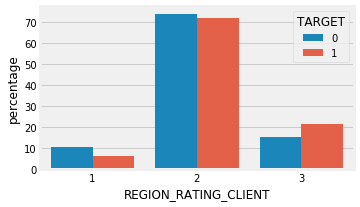

Group summary
    TARGET  REGION_RATING_CLIENT  percentage
2       0                     1   10.840650
5       1                     1    6.251762
0       0                     2   73.960861
3       1                     2   72.132931
1       0                     3   15.198489
4       1                     3   21.615307

Statistical summary:
        REGION_RATING_CLIENT_TARGET_0  REGION_RATING_CLIENT_TARGET_1
count                  282686.000000                   24825.000000
mean                        2.043578                       2.153635
std                         0.508422                       0.505052
min                         1.000000                       1.000000
25%                         2.000000                       2.000000
50%                         2.000000                       2.000000
75%                         2.000000                       2.000000
max                         3.000000                       3.000000


In [183]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[7]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[7]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[7]))
sns.barplot(x="REGION_RATING_CLIENT", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('REGION_RATING_CLIENT_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('REGION_RATING_CLIENT_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

## Variable: REGION_RATING_CLIENT_W_CITY

Integer variable name: REGION_RATING_CLIENT_W_CITY
% missing value 0.0


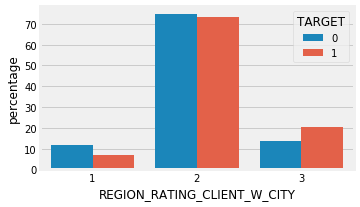

Group summary
    TARGET  REGION_RATING_CLIENT_W_CITY  percentage
2       0                            1   11.501454
5       1                            1    6.662638
0       0                            2   74.752199
3       1                            2   73.192346
1       0                            3   13.746348
4       1                            3   20.145015

Statistical summary:
        FLAG_MOBIL_TARGET_0  FLAG_MOBIL_TARGET_1
count        282686.000000         24825.000000
mean              2.022449             2.134824
std               0.501971             0.499909
min               1.000000             1.000000
25%               2.000000             2.000000
50%               2.000000             2.000000
75%               2.000000             2.000000
max               3.000000             3.000000


In [184]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[8]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[8]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[8]))
sns.barplot(x="REGION_RATING_CLIENT_W_CITY", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_MOBIL_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_MOBIL_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

## Variable: REG_REGION_NOT_LIVE_REGION

Integer variable name: REG_REGION_NOT_LIVE_REGION
% missing value 0.0


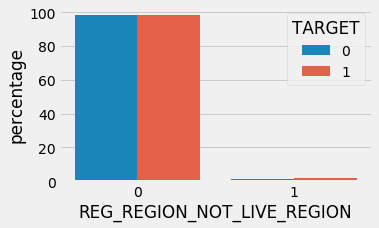

Group summary
    TARGET  REG_REGION_NOT_LIVE_REGION  percentage
0       0                           0   98.505763
2       1                           0   98.255791
1       0                           1    1.494237
3       1                           1    1.744209

Statistical summary:
        REG_REGION_NOT_LIVE_REGION_TARGET_0  \
count                        282686.000000   
mean                              0.014942   
std                               0.121323   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       REG_REGION_NOT_LIVE_REGION_TARGET_1  
count                         24825.000000  
mean                              0.017442  
std                               0.130914  
min                               0.000000  
25%                               0.000000  
50%                        

In [79]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[9]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[9]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[9]))
sns.barplot(x="REG_REGION_NOT_LIVE_REGION", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('REG_REGION_NOT_LIVE_REGION_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('REG_REGION_NOT_LIVE_REGION_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['REG_REGION_NOT_LIVE_REGION'])
test = test.drop(columns=['REG_REGION_NOT_LIVE_REGION'])

Not differentiable and we will get rid of it.

## Variable: REG_REGION_NOT_WORK_REGION

Integer variable name: REG_REGION_NOT_WORK_REGION
% missing value 0.0


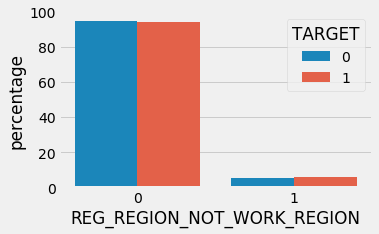

Group summary
    TARGET  REG_REGION_NOT_WORK_REGION  percentage
0       0                           0   94.968269
2       1                           0   94.408862
1       0                           1    5.031731
3       1                           1    5.591138

Statistical summary:
        REG_REGION_NOT_WORK_REGION_TARGET_0  \
count                        282686.000000   
mean                              0.050317   
std                               0.218599   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       REG_REGION_NOT_WORK_REGION_TARGET_1  
count                         24825.000000  
mean                              0.055911  
std                               0.229755  
min                               0.000000  
25%                               0.000000  
50%                        

In [80]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[10]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[10]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[10]))
sns.barplot(x="REG_REGION_NOT_WORK_REGION", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('REG_REGION_NOT_WORK_REGION_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('REG_REGION_NOT_WORK_REGION_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

train = train.drop(columns=['REG_REGION_NOT_WORK_REGION'])
test = test.drop(columns=['REG_REGION_NOT_WORK_REGION'])

Not important variable

## Variable: LIVE_REGION_NOT_WORK_REGION

Integer variable name: LIVE_REGION_NOT_WORK_REGION
% missing value 0.0


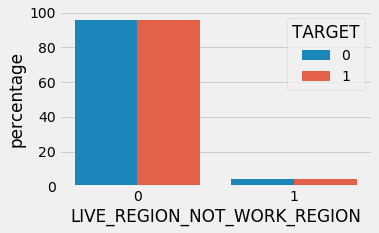

Group summary
    TARGET  LIVE_REGION_NOT_WORK_REGION  percentage
0       0                            0   95.950631
2       1                            0   95.746224
1       0                            1    4.049369
3       1                            1    4.253776

Statistical summary:
        LIVE_REGION_NOT_WORK_REGION_TARGET_0  \
count                         282686.000000   
mean                               0.040494   
std                                0.197114   
min                                0.000000   
25%                                0.000000   
50%                                0.000000   
75%                                0.000000   
max                                1.000000   

       LIVE_REGION_NOT_WORK_REGION_TARGET_1  
count                          24825.000000  
mean                               0.042538  
std                                0.201817  
min                                0.000000  
25%                                0.000000  
50%    

In [81]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[11]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[11]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[11]))
sns.barplot(x="LIVE_REGION_NOT_WORK_REGION", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('LIVE_REGION_NOT_WORK_REGION_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('LIVE_REGION_NOT_WORK_REGION_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['LIVE_REGION_NOT_WORK_REGION'])
test = test.drop(columns=['LIVE_REGION_NOT_WORK_REGION'])

## Variable: REG_CITY_NOT_LIVE_CITY

Integer variable name: REG_CITY_NOT_LIVE_CITY
% missing value 0.0


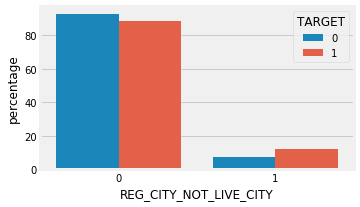

,REG_CITY_NOT_LIVE_CITY_TARGET_0,REG_CITY_NOT_LIVE_CITY_TARGET_1
count,282686.000000,24825.000000
mean,0.074641,0.118389
std,0.262812,0.323074
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [191]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[12]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[12]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[12]))
sns.barplot(x="REG_CITY_NOT_LIVE_CITY", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('REG_CITY_NOT_LIVE_CITY_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('REG_CITY_NOT_LIVE_CITY_TARGET_1')
#print('Target 1:', target_1_des)
pd.concat([target_0_des, target_1_des], axis=1)

## Variable: REG_CITY_NOT_WORK_CITY

Integer variable name: REG_CITY_NOT_WORK_CITY
% missing value 0.0


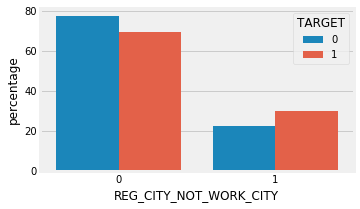

Group summary
    TARGET  REG_CITY_NOT_WORK_CITY  percentage
0       0                       0   77.591037
2       1                       0   69.707956
1       0                       1   22.408963
3       1                       1   30.292044

Statistical summary:
        REG_CITY_NOT_WORK_CITY_TARGET_0  REG_CITY_NOT_WORK_CITY_TARGET_1
count                    282686.000000                      24825.00000
mean                          0.224090                          0.30292
std                           0.416982                          0.45953
min                           0.000000                          0.00000
25%                           0.000000                          0.00000
50%                           0.000000                          0.00000
75%                           0.000000                          1.00000
max                           1.000000                          1.00000


In [192]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[13]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[13]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[13]))
sns.barplot(x="REG_CITY_NOT_WORK_CITY", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('REG_CITY_NOT_WORK_CITY_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('REG_CITY_NOT_WORK_CITY_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

## Variable: LIVE_CITY_NOT_WORK_CITY

Integer variable name: LIVE_CITY_NOT_WORK_CITY
% missing value 0.0


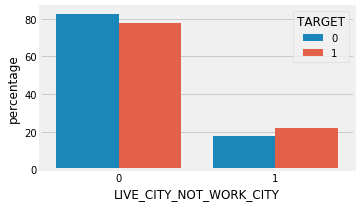

Group summary
    TARGET  LIVE_CITY_NOT_WORK_CITY  percentage
0       0                        0    82.41441
2       1                        0    77.83283
1       0                        1    17.58559
3       1                        1    22.16717

Statistical summary:
        LIVE_CITY_NOT_WORK_CITY_TARGET_0  LIVE_CITY_NOT_WORK_CITY_TARGET_1
count                     282686.000000                      24825.000000
mean                           0.175856                          0.221672
std                            0.380698                          0.415380
min                            0.000000                          0.000000
25%                            0.000000                          0.000000
50%                            0.000000                          0.000000
75%                            0.000000                          0.000000
max                            1.000000                          1.000000


In [193]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[14]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[14]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[14]))
sns.barplot(x="LIVE_CITY_NOT_WORK_CITY", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('LIVE_CITY_NOT_WORK_CITY_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('LIVE_CITY_NOT_WORK_CITY_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

## Variable: FLAG_DOCUMENT_2

Integer variable name: FLAG_DOCUMENT_2
% missing value 0.0


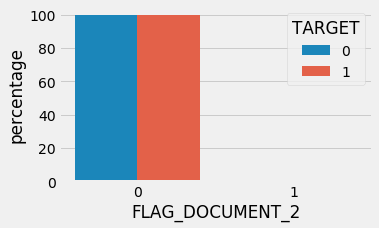

Group summary
    TARGET  FLAG_DOCUMENT_2  percentage
0       0                0   99.996816
2       1                0   99.983887
1       0                1    0.003184
3       1                1    0.016113

Statistical summary:
        FLAG_DOCUMENT_2_TARGET_0  FLAG_DOCUMENT_2_TARGET_1
count             282686.000000              24825.000000
mean                   0.000032                  0.000161
std                    0.005642                  0.012693
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [82]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[15]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[15]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[15]))
sns.barplot(x="FLAG_DOCUMENT_2", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_2_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_2_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_2'])
test = test.drop(columns=['FLAG_DOCUMENT_2'])

All documents are flagegd as '0'. Get rid of it

### Variable: FLAG_DOCUMENT_3

Integer variable name: FLAG_DOCUMENT_3
% missing value 0.0


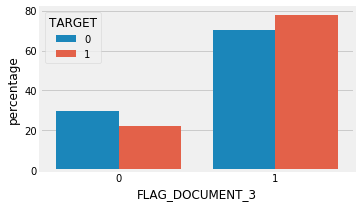

Group summary
    TARGET  FLAG_DOCUMENT_3  percentage
1       0                0   29.593966
3       1                0   22.207452
0       0                1   70.406034
2       1                1   77.792548

Statistical summary:
        FLAG_DOCUMENT_3_TARGET_0 FLAG_DOCUMENT_3_TARGET_1
count                    282686                    24825
unique                        2                        2
top                        True                     True
freq                     199028                    19312


In [196]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[16]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[16]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[16]))
sns.barplot(x="FLAG_DOCUMENT_3", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_3_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_3_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

### Variable: FLAG_DOCUMENT_4

Integer variable name: FLAG_DOCUMENT_4
% missing value 0.0


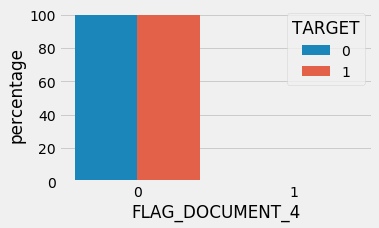

Group summary
    TARGET  FLAG_DOCUMENT_4  percentage
0       0                0   99.991156
2       1                0  100.000000
1       0                1    0.008844

Statistical summary:
        FLAG_DOCUMENT_4_TARGET_0  FLAG_DOCUMENT_4_TARGET_1
count             282686.000000                   24825.0
mean                   0.000088                       0.0
std                    0.009404                       0.0
min                    0.000000                       0.0
25%                    0.000000                       0.0
50%                    0.000000                       0.0
75%                    0.000000                       0.0
max                    1.000000                       0.0


In [83]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[17]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[17]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[17]))
sns.barplot(x="FLAG_DOCUMENT_4", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_4_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_4_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_4'])
test = test.drop(columns=['FLAG_DOCUMENT_4'])

All docs are flagged as 0, not useful variable,

### Variable: FLAG_DOCUMENT_5

Integer variable name: FLAG_DOCUMENT_5
% missing value 0.0


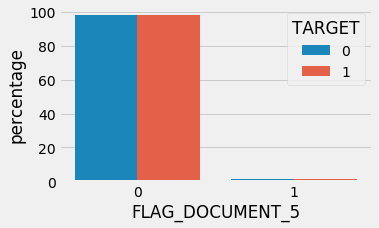

Group summary
    TARGET  FLAG_DOCUMENT_5  percentage
0       0                0   98.487368
2       1                0   98.501511
1       0                1    1.512632
3       1                1    1.498489

Statistical summary:
        FLAG_DOCUMENT_5_TARGET_0  FLAG_DOCUMENT_5_TARGET_1
count             282686.000000              24825.000000
mean                   0.015126                  0.014985
std                    0.122056                  0.121495
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [84]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[18]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[18]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[18]))
sns.barplot(x="FLAG_DOCUMENT_5", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_5_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_5_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_5'])
test = test.drop(columns=['FLAG_DOCUMENT_5'])

### Variable: FLAG_DOCUMENT_6

Integer variable name: FLAG_DOCUMENT_6
% missing value 0.0


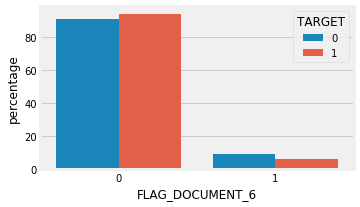

Group summary
    TARGET  FLAG_DOCUMENT_6  percentage
0       0                0   90.954274
2       1                0   93.929507
1       0                1    9.045726
3       1                1    6.070493

Statistical summary:
        FLAG_DOCUMENT_6_TARGET_0  FLAG_DOCUMENT_6_TARGET_1
count             282686.000000              24825.000000
mean                   0.090457                  0.060705
std                    0.286836                  0.238793
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [201]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[19]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[19]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[19]))
sns.barplot(x="FLAG_DOCUMENT_6", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_6_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_6_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

### Variable: FLAG_DOCUMENT_7

Integer variable name: FLAG_DOCUMENT_7
% missing value 0.0


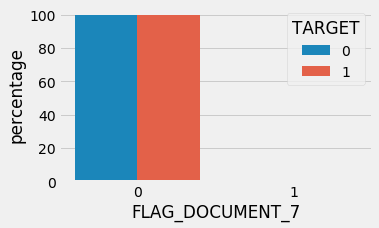

Group summary
    TARGET  FLAG_DOCUMENT_7  percentage
0       0                0   99.980190
2       1                0   99.987915
1       0                1    0.019810
3       1                1    0.012085

Statistical summary:
        FLAG_DOCUMENT_7_TARGET_0  FLAG_DOCUMENT_7_TARGET_1
count             282686.000000              24825.000000
mean                   0.000198                  0.000121
std                    0.014073                  0.010993
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [85]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[20]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[20]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[20]))
sns.barplot(x="FLAG_DOCUMENT_7", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_7_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_7_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_7'])
test = test.drop(columns=['FLAG_DOCUMENT_7'])

### Variable: FLAG_DOCUMENT_8

Integer variable name: FLAG_DOCUMENT_8
% missing value 0.0


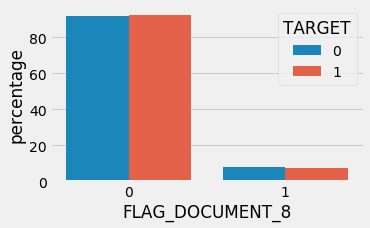

Group summary
    TARGET  FLAG_DOCUMENT_8  percentage
0       0                0   91.797259
2       1                0   92.604230
1       0                1    8.202741
3       1                1    7.395770

Statistical summary:
        FLAG_DOCUMENT_8_TARGET_0  FLAG_DOCUMENT_8_TARGET_1
count             282686.000000              24825.000000
mean                   0.082027                  0.073958
std                    0.274407                  0.261707
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [86]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[21]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[21]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[21]))
sns.barplot(x="FLAG_DOCUMENT_8", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_8_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_8_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary:\n', pd.concat([target_0_des, target_1_des], axis=1))

train = train.drop(columns=['FLAG_DOCUMENT_8'])
test = test.drop(columns=['FLAG_DOCUMENT_8'])

### Variable: FLAG_DOCUMENT_9

Integer variable name: FLAG_DOCUMENT_9
% missing value 0.0


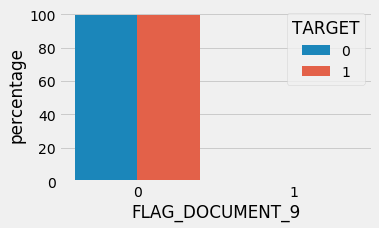

Group summary
    TARGET  FLAG_DOCUMENT_9  percentage
0       0                0   99.602386
2       1                0   99.701913
1       0                1    0.397614
3       1                1    0.298087

Statistical summary
        FLAG_DOCUMENT_9_TARGET_0  FLAG_DOCUMENT_9_TARGET_1
count             282686.000000              24825.000000
mean                   0.003976                  0.002981
std                    0.062931                  0.054517
min                    0.000000                  0.000000
25%                    0.000000                  0.000000
50%                    0.000000                  0.000000
75%                    0.000000                  0.000000
max                    1.000000                  1.000000


In [87]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[22]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[22]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[22]))
sns.barplot(x="FLAG_DOCUMENT_9", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_9_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_9_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_9'])
test = test.drop(columns=['FLAG_DOCUMENT_9'])

### Variable: FLAG_DOCUMENT_10

Integer variable name: FLAG_DOCUMENT_10
% missing value 0.0


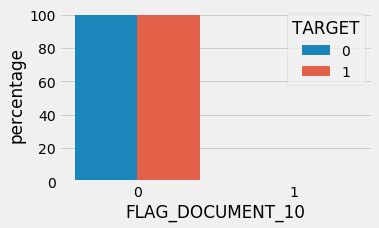

Group summary
    TARGET  FLAG_DOCUMENT_10  percentage
0       0                 0   99.997524
2       1                 0  100.000000
1       0                 1    0.002476

Statistical summary
        FLAG_DOCUMENT_10_TARGET_0  FLAG_DOCUMENT_10_TARGET_1
count              282686.000000                    24825.0
mean                    0.000025                        0.0
std                     0.004976                        0.0
min                     0.000000                        0.0
25%                     0.000000                        0.0
50%                     0.000000                        0.0
75%                     0.000000                        0.0
max                     1.000000                        0.0


In [88]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[23]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[23]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[23]))
sns.barplot(x="FLAG_DOCUMENT_10", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_10_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_10_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_10'])
test = test.drop(columns=['FLAG_DOCUMENT_10'])

### Variable: FLAG_DOCUMENT_11

Integer variable name: FLAG_DOCUMENT_11
% missing value 0.0


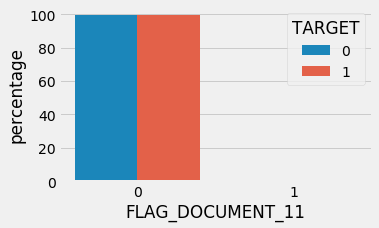

Group summary
    TARGET  FLAG_DOCUMENT_11  percentage
0       0                 0   99.600971
2       1                 0   99.697885
1       0                 1    0.399029
3       1                 1    0.302115

Statistical summary
        FLAG_DOCUMENT_11_TARGET_0  FLAG_DOCUMENT_11_TARGET_1
count              282686.000000               24825.000000
mean                    0.003990                   0.003021
std                     0.063043                   0.054883
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [89]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[24]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[24]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[24]))
sns.barplot(x="FLAG_DOCUMENT_11", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_11_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_11_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_11'])
test = test.drop(columns=['FLAG_DOCUMENT_11'])

### Variable: FLAG_DOCUMENT_12

Integer variable name: FLAG_DOCUMENT_12
% missing value 0.0


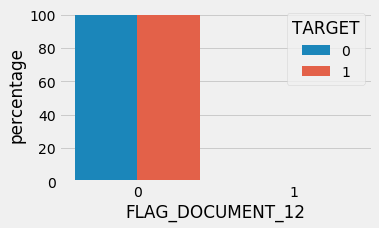

Group summary
    TARGET  FLAG_DOCUMENT_12  percentage
0       0                 0   99.999293
2       1                 0  100.000000
1       0                 1    0.000707

Statistical summary
        FLAG_DOCUMENT_12_TARGET_0  FLAG_DOCUMENT_12_TARGET_1
count              282686.000000                    24825.0
mean                    0.000007                        0.0
std                     0.002660                        0.0
min                     0.000000                        0.0
25%                     0.000000                        0.0
50%                     0.000000                        0.0
75%                     0.000000                        0.0
max                     1.000000                        0.0


In [90]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[25]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[25]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[25]))
sns.barplot(x="FLAG_DOCUMENT_12", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_12_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_12_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_12'])
test = test.drop(columns=['FLAG_DOCUMENT_12'])

### Variable: FLAG_DOCUMENT_13

Integer variable name: FLAG_DOCUMENT_13
% missing value 0.0


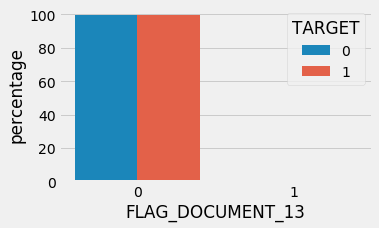

Group summary
    TARGET  FLAG_DOCUMENT_13  percentage
0       0                 0   99.627148
2       1                 0   99.879154
1       0                 1    0.372852
3       1                 1    0.120846

Statistical summary
        FLAG_DOCUMENT_13_TARGET_0  FLAG_DOCUMENT_13_TARGET_1
count              282686.000000               24825.000000
mean                    0.003729                   0.001208
std                     0.060948                   0.034743
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [91]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[26]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[26]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[26]))
sns.barplot(x="FLAG_DOCUMENT_13", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_13_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_13_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_13'])
test = test.drop(columns=['FLAG_DOCUMENT_13'])

### Variable: FLAG_DOCUMENT_14

Integer variable name: FLAG_DOCUMENT_14
% missing value 0.0


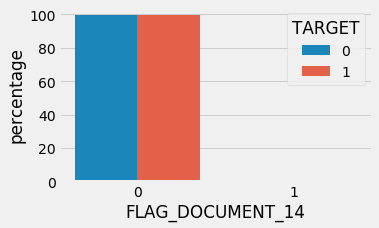

Group summary
    TARGET  FLAG_DOCUMENT_14  percentage
0       0                 0   99.691177
2       1                 0   99.879154
1       0                 1    0.308823
3       1                 1    0.120846

Statistical summary
        FLAG_DOCUMENT_14_TARGET_0  FLAG_DOCUMENT_14_TARGET_1
count              282686.000000               24825.000000
mean                    0.003088                   0.001208
std                     0.055486                   0.034743
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [92]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[27]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[27]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[27]))
sns.barplot(x="FLAG_DOCUMENT_14", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_14_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_14_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_14'])
test = test.drop(columns=['FLAG_DOCUMENT_14'])

### FLAG_DOCUMENT_15

Integer variable name: FLAG_DOCUMENT_15
% missing value 0.0


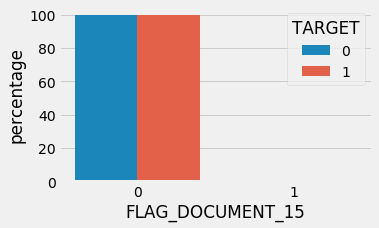

Group summary
    TARGET  FLAG_DOCUMENT_15  percentage
0       0                 0   99.872296
2       1                 0   99.955690
1       0                 1    0.127704
3       1                 1    0.044310

Statistical summary
        FLAG_DOCUMENT_15_TARGET_0  FLAG_DOCUMENT_15_TARGET_1
count              282686.000000               24825.000000
mean                    0.001277                   0.000443
std                     0.035713                   0.021046
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [93]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[28]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[28]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[28]))
sns.barplot(x="FLAG_DOCUMENT_15", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_15_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_15_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_15'])
test = test.drop(columns=['FLAG_DOCUMENT_15'])

### Variable: FLAG_DOCUMENT_16

Integer variable name: FLAG_DOCUMENT_16
% missing value 0.0


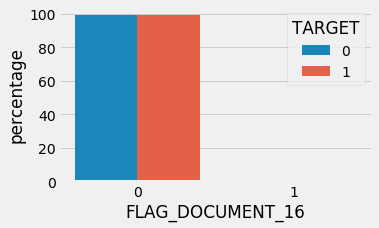

Group summary
    TARGET  FLAG_DOCUMENT_16  percentage
0       0                 0   98.973066
2       1                 0   99.395770
1       0                 1    1.026934
3       1                 1    0.604230

Statistical summary
        FLAG_DOCUMENT_16_TARGET_0  FLAG_DOCUMENT_16_TARGET_1
count              282686.000000               24825.000000
mean                    0.010269                   0.006042
std                     0.100816                   0.077499
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [94]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[29]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[29]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[29]))
sns.barplot(x="FLAG_DOCUMENT_16", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_16_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_16_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_16'])
test = test.drop(columns=['FLAG_DOCUMENT_16'])

### Variable: FLAG_DOCUMENT_17

Integer variable name: FLAG_DOCUMENT_17
% missing value 0.0


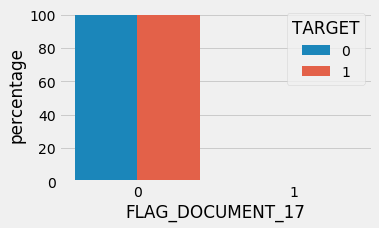

Group summary
    TARGET  FLAG_DOCUMENT_17  percentage
0       0                 0   99.971700
2       1                 0   99.991944
1       0                 1    0.028300
3       1                 1    0.008056

Statistical summary
        FLAG_DOCUMENT_17_TARGET_0  FLAG_DOCUMENT_17_TARGET_1
count              282686.000000               24825.000000
mean                    0.000283                   0.000081
std                     0.016820                   0.008976
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [95]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 
                                      'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
var_n = var_names[30]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[30]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[30]))
sns.barplot(x="FLAG_DOCUMENT_17", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_17_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_17_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_17'])
test = test.drop(columns=['FLAG_DOCUMENT_17'])

### Variable: FLAG_DOCUMENT_18

Integer variable name: FLAG_DOCUMENT_18
% missing value 0.0


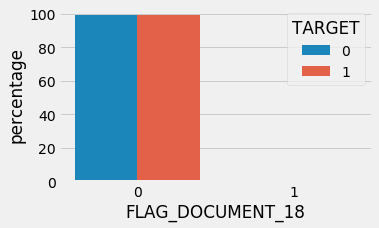

Group summary
    TARGET  FLAG_DOCUMENT_18  percentage
0       0                 0   99.165859
2       1                 0   99.427996
1       0                 1    0.834141
3       1                 1    0.572004

Statistical summary
        FLAG_DOCUMENT_18_TARGET_0  FLAG_DOCUMENT_18_TARGET_1
count              282686.000000               24825.000000
mean                    0.008341                   0.005720
std                     0.090950                   0.075416
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [96]:
var_names = var_int_cnt.columns
var_n = var_names[31]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[31]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[31]))
sns.barplot(x="FLAG_DOCUMENT_18", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_18_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_18_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_18'])
test = test.drop(columns=['FLAG_DOCUMENT_18'])

### Variable: FLAG_DOCUMENT_19

Integer variable name: FLAG_DOCUMENT_19
% missing value 0.0


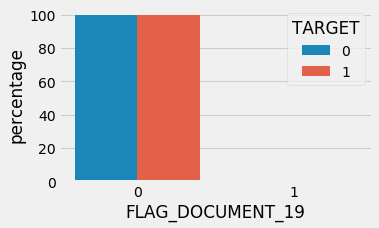

Group summary
    TARGET  FLAG_DOCUMENT_19  percentage
0       0                 0   99.939509
2       1                 0   99.951662
1       0                 1    0.060491
3       1                 1    0.048338

Statistical summary
        FLAG_DOCUMENT_19_TARGET_0  FLAG_DOCUMENT_19_TARGET_1
count              282686.000000               24825.000000
mean                    0.000605                   0.000483
std                     0.024588                   0.021981
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [97]:
var_names = var_int_cnt.columns
var_n = var_names[32]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[32]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[32]))
sns.barplot(x="FLAG_DOCUMENT_19", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_19_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_19_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_19'])
test = test.drop(columns=['FLAG_DOCUMENT_19'])

### Variable: FLAG_DOCUMENT_20

Integer variable name: FLAG_DOCUMENT_20
% missing value 0.0


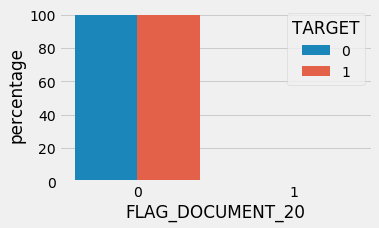

Group summary
    TARGET  FLAG_DOCUMENT_20  percentage
0       0                 0   99.949414
2       1                 0   99.947633
1       0                 1    0.050586
3       1                 1    0.052367

Statistical summary
        FLAG_DOCUMENT_20_TARGET_0  FLAG_DOCUMENT_20_TARGET_1
count              282686.000000               24825.000000
mean                    0.000506                   0.000524
std                     0.022486                   0.022878
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [98]:
var_names = var_int_cnt.columns
var_n = var_names[33]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[33]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[33]))
sns.barplot(x="FLAG_DOCUMENT_20", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_20_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_20_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_20'])
test = test.drop(columns=['FLAG_DOCUMENT_20'])

### Variable: FLAG_DOCUMENT_21

Integer variable name: FLAG_DOCUMENT_21
% missing value 0.0


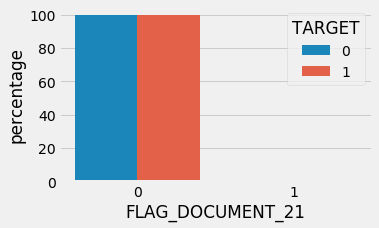

Group summary
    TARGET  FLAG_DOCUMENT_21  percentage
0       0                 0   99.968516
2       1                 0   99.943605
1       0                 1    0.031484
3       1                 1    0.056395

Statistical summary
        FLAG_DOCUMENT_21_TARGET_0  FLAG_DOCUMENT_21_TARGET_1
count              282686.000000               24825.000000
mean                    0.000315                   0.000564
std                     0.017741                   0.023741
min                     0.000000                   0.000000
25%                     0.000000                   0.000000
50%                     0.000000                   0.000000
75%                     0.000000                   0.000000
max                     1.000000                   1.000000


In [99]:
var_names = var_int_cnt.columns
var_n = var_names[34]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_cnt.groupby([var_names[0]])[var_names[34]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[34]))
sns.barplot(x="FLAG_DOCUMENT_21", y='percentage', hue='TARGET', data=var)
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('FLAG_DOCUMENT_21_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('FLAG_DOCUMENT_21_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

#dropping the column
train = train.drop(columns=['FLAG_DOCUMENT_21'])
test = test.drop(columns=['FLAG_DOCUMENT_21'])

### Variable: DAYS_BIRTH

Integer variable name: DAYS_BIRTH
% missing value 0.0


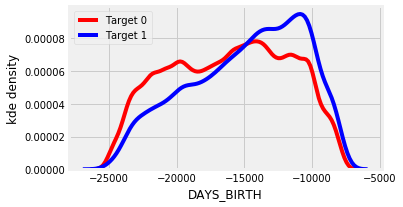


Statistical summary
        DAYS_BIRTH_TARGET_0  DAYS_BIRTH_TARGET_1
count        282686.000000         24825.000000
mean         -16138.176397        -14884.828077
std            4364.200856          4192.844583
min          -25229.000000        -25168.000000
25%          -19793.750000        -18037.000000
50%          -15877.000000        -14282.000000
75%          -12536.000000        -11396.000000
max           -7489.000000         -7678.000000


In [231]:
var_int_dist = pd.concat([train.DAYS_BIRTH, train.DAYS_EMPLOYED, train.DAYS_ID_PUBLISH, 
                          train.DAYS_LAST_PHONE_CHANGE, train.CNT_CHILDREN, train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var = var_names[0]
print('Integer variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)

#sns.kdeplot(train[var], label = 'all', color='black')
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red')
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue')
plt.xlabel(var)
plt.ylabel('kde density')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,3
plt.show()

# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('DAYS_BIRTH_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('DAYS_BIRTH_TARGET_1')
#print('Target 1:', target_1_des)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

### Variable: DAYS_EMPLOYED

Integer variable name: DAYS_EMPLOYED
% missing value 0.0


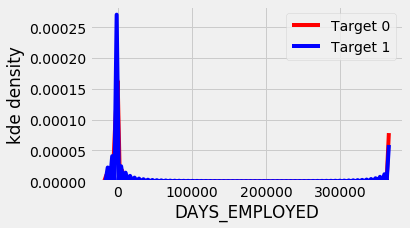


Statistical summary
        DAYS_EMPLOYED_TARGET_0  DAYS_EMPLOYED_TARGET_1
count           282686.000000            24825.000000
mean             65696.146123            42394.675448
std             142877.810161           119484.634253
min             -17912.000000           -16069.000000
25%              -2813.000000            -2156.000000
50%              -1235.000000            -1034.000000
75%               -278.000000             -379.000000
max             365243.000000           365243.000000
% anomaly in train.DAYS_EMPLOYED: 18.01
% anomaly in test.DAYS_EMPLOYED: 19.03


In [100]:
var_int_dist = pd.concat([train.DAYS_BIRTH, train.DAYS_EMPLOYED, train.DAYS_ID_PUBLISH, 
                          train.DAYS_LAST_PHONE_CHANGE, train.CNT_CHILDREN, train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var = var_names[1]
print('Integer variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)

#sns.kdeplot(train[var], label = 'all', color='black')
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red')
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue')
plt.xlabel(var)
plt.ylabel('kde density')
#plt.xscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 6,3
plt.show()

# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('DAYS_EMPLOYED_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('DAYS_EMPLOYED_TARGET_1')
#print('Target 1:', target_1_des)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))
# Anomalies in data
print('% anomaly in train.DAYS_EMPLOYED: {:05.2f}'.format(len(train[train['DAYS_EMPLOYED']> 0]['DAYS_EMPLOYED'])
                                   /len(train['DAYS_EMPLOYED'])*100))
print('% anomaly in test.DAYS_EMPLOYED: {:05.2f}'.format(len(test[test['DAYS_EMPLOYED']> 0]['DAYS_EMPLOYED'])
                                   /len(test['DAYS_EMPLOYED'])*100))

#df.replace(0, 5) replace the anomalies with median
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace(365243, train['DAYS_EMPLOYED'].median())
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].replace(365243, train['DAYS_EMPLOYED'].median())

There are 18% anomalies in DAYS_EMPLOYED train dataset. It seemed to defaultvalue for employment days set as 365243.000000. We will replace the anomalies with 0.

### Variable: DAYS_ID_PUBLISH

Integer variable name: DAYS_ID_PUBLISH
% missing value 0.0


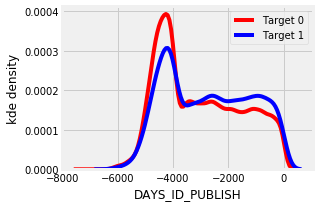


Statistical summary
        DAYS_ID_PUBLISH_TARGET_0  DAYS_ID_PUBLISH_TARGET_1
count             282686.000000              24825.000000
mean               -3017.219788              -2732.099617
std                 1506.614090               1516.975313
min                -7197.000000              -6207.000000
25%                -4313.000000              -4119.000000
50%                -3295.000000              -2797.000000
75%                -1755.000000              -1392.000000
max                    0.000000                  0.000000


In [244]:
var_int_dist = pd.concat([train.DAYS_BIRTH, train.DAYS_EMPLOYED, train.DAYS_ID_PUBLISH, 
                          train.DAYS_LAST_PHONE_CHANGE, train.CNT_CHILDREN, train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var = var_names[2]
print('Integer variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)

#sns.kdeplot(train[var], label = 'all', color='black')
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red')
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue')
plt.xlabel(var)
plt.ylabel('kde density')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,3
plt.show()

# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('DAYS_ID_PUBLISH_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('DAYS_ID_PUBLISH_TARGET_1')
#print('Target 1:', target_1_des)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

### Variable: DAYS_LAST_PHONE_CHANGE

Integer variable name: DAYS_LAST_PHONE_CHANGE
% missing value 0.0


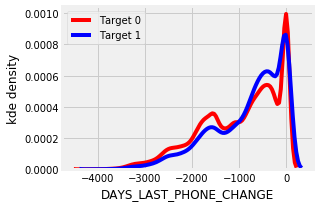


Statistical summary
        DAYS_LAST_PHONE_CHANGE_TARGET_0  DAYS_LAST_PHONE_CHANGE_TARGET_1
count                    282686.000000                     24825.000000
mean                       -976.332458                      -808.799927
std                         831.066711                       758.102539
min                       -4292.000000                     -4070.000000
25%                       -1586.000000                     -1301.000000
50%                        -776.000000                      -594.000000
75%                        -281.000000                      -194.000000
max                           0.000000                         0.000000


In [245]:
var_int_dist = pd.concat([train.DAYS_BIRTH, train.DAYS_EMPLOYED, train.DAYS_ID_PUBLISH, 
                          train.DAYS_LAST_PHONE_CHANGE, train.CNT_CHILDREN, train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var = var_names[3]
print('Integer variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)

#sns.kdeplot(train[var], label = 'all', color='black')
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red')
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue')
plt.xlabel(var)
plt.ylabel('kde density')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,3
plt.show()

# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('DAYS_LAST_PHONE_CHANGE_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('DAYS_LAST_PHONE_CHANGE_TARGET_1')
#print('Target 1:', target_1_des)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

### Variable: CNT_CHILDREN

Integer variable name: CNT_CHILDREN
% missing value 0.0


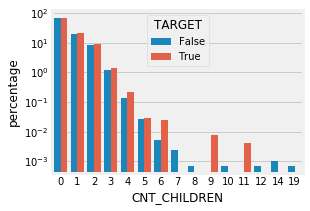

Group summary
     TARGET  CNT_CHILDREN  percentage
0    False             0   70.311936
13    True             0   66.904330
1    False             1   19.691460
14    True             1   21.969789
2    False             2    8.637145
15    True             2    9.397784
16    True             3    1.442095
3    False             3    1.188244
17    True             4    0.221551
4    False             4    0.132302
5    False             5    0.027239
18    True             5    0.028197
6    False             6    0.005306
19    True             6    0.024169
7    False             7    0.002476
9    False             8    0.000707
20    True             9    0.008056
10   False            10    0.000707
21    True            11    0.004028
11   False            12    0.000707
8    False            14    0.001061
12   False            19    0.000707

Statistical summary
        CNT_CHILDREN_TARGET_0  CNT_CHILDREN_TARGET_1
count          282686.000000           24825.000000
mean    

In [246]:
var_int_dist = pd.concat([train.TARGET, train.DAYS_BIRTH, train.DAYS_EMPLOYED, train.DAYS_ID_PUBLISH, 
                          train.DAYS_LAST_PHONE_CHANGE, train.CNT_CHILDREN, train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var_n = var_names[5]
print('Integer variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution of variable:
# This is how we have to present the bar plot: using the percentage, not count
var = (var_int_dist.groupby([var_names[0]])[var_names[5]].value_counts(normalize=True).rename('percentage').
       mul(100).reset_index().sort_values(var_names[5]))
sns.barplot(x="CNT_CHILDREN", y='percentage', hue='TARGET', data=var)
plt.yscale('log')
plt.show()
# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var_n].describe().rename('CNT_CHILDREN_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var_n].describe().rename('CNT_CHILDREN_TARGET_1')
#print('Target 1:', target_1_des)
print('Group summary\n', var)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

### Variable: HOUR_APPR_PROCESS_START

Integer variable name: HOUR_APPR_PROCESS_START
% missing value 0.0


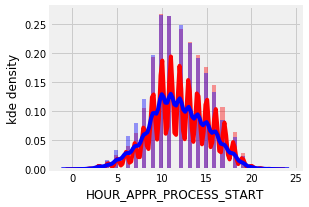


Statistical summary
        HOUR_APPR_PROCESS_START_TARGET_0  HOUR_APPR_PROCESS_START_TARGET_1
count                     282686.000000                      24825.000000
mean                          12.086807                         11.797100
std                            3.263173                          3.284299
min                            0.000000                          0.000000
25%                           10.000000                         10.000000
50%                           12.000000                         12.000000
75%                           14.000000                         14.000000
max                           23.000000                         23.000000


In [247]:
var_int_dist = pd.concat([train.DAYS_BIRTH, train.DAYS_EMPLOYED, train.DAYS_ID_PUBLISH, 
                          train.DAYS_LAST_PHONE_CHANGE, train.CNT_CHILDREN, train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
var = var_names[5]
print('Integer variable name:', var)
# % missing value
print('% missing value', train[var].isnull().sum()/len(train[var])* 100)

#sns.kdeplot(train[var], label = 'all', color='black')
sns.distplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red')
sns.distplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue')
plt.xlabel(var)
plt.ylabel('kde density')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,3
plt.show()

# Statistical summary
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('HOUR_APPR_PROCESS_START_TARGET_0')
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('HOUR_APPR_PROCESS_START_TARGET_1')
#print('Target 1:', target_1_des)
print('\nStatistical summary\n', pd.concat([target_0_des, target_1_des], axis=1))

## variable type: categorical

### Variable: NAME_CONTRACT_TYPE  

Categorical variable name: NAME_CONTRACT_TYPE
% missing value 0.0


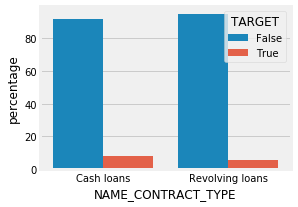

Group summary
   NAME_CONTRACT_TYPE  TARGET  percentage
0         Cash loans   False   91.654087
1         Cash loans    True    8.345913
2    Revolving loans   False   94.521671
3    Revolving loans    True    5.478329


In [248]:
var_obj = obj.columns
var_n = var_obj[0]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.show()

print('Group summary\n', var)

### Variable: CODE_GENDER

Categorical variable name: CODE_GENDER
% missing value 0.0


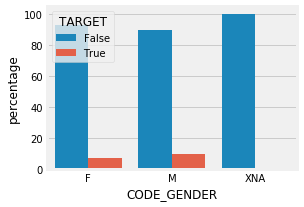

Group summary
   CODE_GENDER  TARGET  percentage
0           F   False   93.000672
1           F    True    6.999328
2           M   False   89.858080
3           M    True   10.141920
4         XNA   False  100.000000


In [249]:
var_obj = obj.columns
var_n = var_obj[1]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.show()
print('Group summary\n', var)

### Variable: FLAG_OWN_CAR

Categorical variable name: FLAG_OWN_CAR
% missing value 0.0


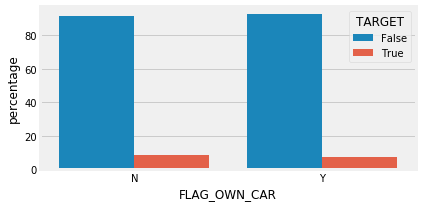

Group summary
   FLAG_OWN_CAR  TARGET  percentage
0            N   False   91.499773
1            N    True    8.500227
2            Y   False   92.756270
3            Y    True    7.243730


In [250]:
var_obj = obj.columns
var_n = var_obj[2]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 4,3
plt.show()
print('Group summary\n', var)

### Variable: FLAG_OWN_REALTY

Categorical variable name: FLAG_OWN_REALTY
% missing value 0.0


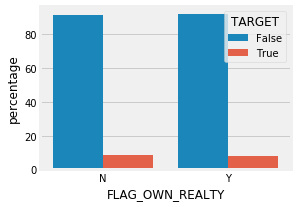

Group summary
   FLAG_OWN_REALTY  TARGET  percentage
0               N   False   91.675071
1               N    True    8.324929
2               Y   False   92.038423
3               Y    True    7.961577


In [251]:
var_obj = obj.columns
var_n = var_obj[3]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 4,3
plt.show()
print('Group summary\n', var)

### Variable: NAME_TYPE_SUITE

Categorical variable name: NAME_TYPE_SUITE
% missing value 0.42014757195677555


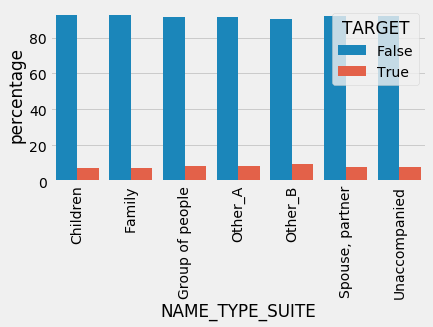

Group summary
     NAME_TYPE_SUITE  TARGET  percentage
0          Children   False   92.623202
1          Children    True    7.376798
2            Family   False   92.505417
3            Family    True    7.494583
4   Group of people   False   91.512915
5   Group of people    True    8.487085
6           Other_A   False   91.224018
7           Other_A    True    8.775982
8           Other_B   False   90.169492
9           Other_B    True    9.830508
10  Spouse, partner   False   92.128408
11  Spouse, partner    True    7.871592
12    Unaccompanied   False   91.816953
13    Unaccompanied    True    8.183047
category
[Unaccompanied, Family, Spouse, partner, Children, Other_A, NaN, Other_B, Group of people]
Categories (7, object): [Unaccompanied, Family, Spouse, partner, Children, Other_A, Other_B, Group of people]


In [101]:
var_obj = obj.columns
var_n = var_obj[4]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

# dealing with missing values
table = train
var = 'NAME_TYPE_SUITE'
print(table[var].dtype)
print(table[var].unique()) # unique value type
table[var] = table[var].fillna('Unaccompanied')
test[var] = test[var].fillna('Unaccompanied')

### Variable: NAME_INCOME_TYPE

Categorical variable name: NAME_INCOME_TYPE
% missing value 0.0


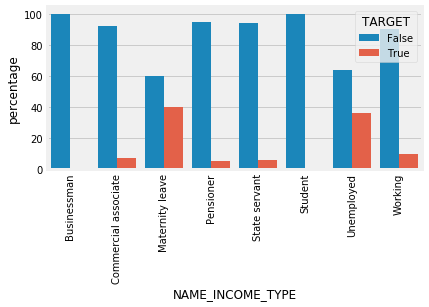

Group summary
         NAME_INCOME_TYPE  TARGET  percentage
0            Businessman   False  100.000000
1   Commercial associate   False   92.515743
2   Commercial associate    True    7.484257
3        Maternity leave   False   60.000000
4        Maternity leave    True   40.000000
5              Pensioner   False   94.613634
6              Pensioner    True    5.386366
7          State servant   False   94.245035
8          State servant    True    5.754965
9                Student   False  100.000000
10            Unemployed   False   63.636364
11            Unemployed    True   36.363636
12               Working   False   90.411528
13               Working    True    9.588472


In [253]:
var_obj = obj.columns
var_n = var_obj[5]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

100% of businessmen and students repaid the loan in time. Unemployed and women in maternity leave had maximum difficulties in repaying loans 

### Variable: NAME_EDUCATION_TYPE

Categorical variable name: NAME_EDUCATION_TYPE
% missing value 0.0


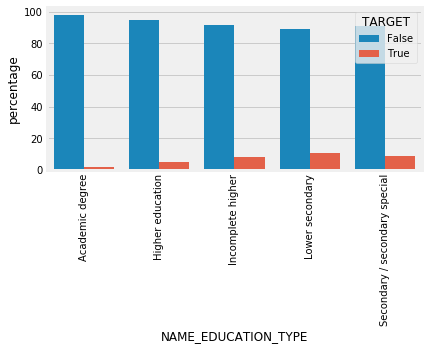

Group summary
              NAME_EDUCATION_TYPE  TARGET  percentage
0                Academic degree   False   98.170732
1                Academic degree    True    1.829268
2               Higher education   False   94.644885
3               Higher education    True    5.355115
4              Incomplete higher   False   91.515034
5              Incomplete higher    True    8.484966
6                Lower secondary   False   89.072327
7                Lower secondary    True   10.927673
8  Secondary / secondary special   False   91.060071
9  Secondary / secondary special    True    8.939929


In [254]:
var_obj = obj.columns
var_n = var_obj[6]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

People with lower secondary education has more difficulty in repaying loan.

### Variable: NAME_FAMILY_STATUS

Categorical variable name: NAME_FAMILY_STATUS
% missing value 0.0


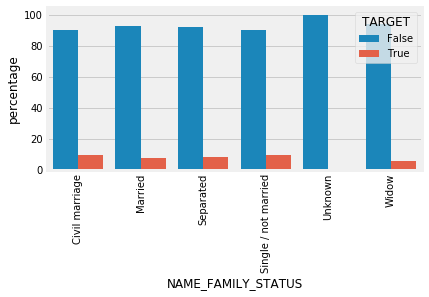

Group summary
       NAME_FAMILY_STATUS  TARGET  percentage
0         Civil marriage   False   90.055416
1         Civil marriage    True    9.944584
2                Married   False   92.440132
3                Married    True    7.559868
4              Separated   False   91.805766
5              Separated    True    8.194234
6   Single / not married   False   90.192325
7   Single / not married    True    9.807675
8                Unknown   False  100.000000
9                  Widow   False   94.175783
10                 Widow    True    5.824217


In [255]:
var_obj = obj.columns
var_n = var_obj[7]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

People under unknown category had 100% repaid loan in time. The type of category suggests it was not recorded properly and should not be used as an important feature.

### Variable: NAME_HOUSING_TYPE

Categorical variable name: NAME_HOUSING_TYPE
% missing value 0.0


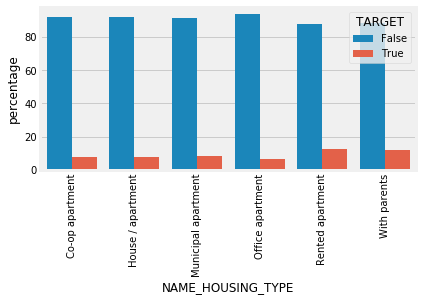

Group summary
       NAME_HOUSING_TYPE  TARGET  percentage
0       Co-op apartment   False   92.067736
1       Co-op apartment    True    7.932264
2     House / apartment   False   92.204289
3     House / apartment    True    7.795711
4   Municipal apartment   False   91.460252
5   Municipal apartment    True    8.539748
6      Office apartment   False   93.427589
7      Office apartment    True    6.572411
8      Rented apartment   False   87.686949
9      Rented apartment    True   12.313051
10         With parents   False   88.301887
11         With parents    True   11.698113


In [256]:
var_obj = obj.columns
var_n = var_obj[8]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

Among all people with rented apartments and people living with parents had more difficulties to repay the loan but not at significant scale

### Variable: OCCUPATION_TYPE

Categorical variable name: OCCUPATION_TYPE
% missing value 31.345545362604916


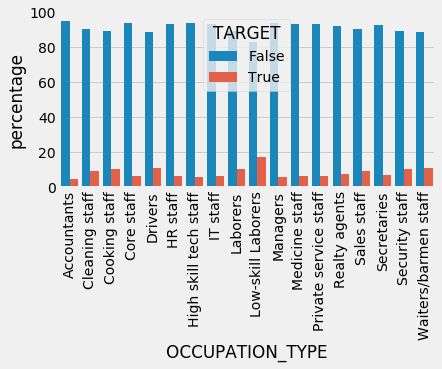

Group summary
           OCCUPATION_TYPE  TARGET  percentage
0             Accountants   False   95.169673
1             Accountants    True    4.830327
2          Cleaning staff   False   90.393295
3          Cleaning staff    True    9.606705
4           Cooking staff   False   89.556004
5           Cooking staff    True   10.443996
6              Core staff   False   93.696046
7              Core staff    True    6.303954
8                 Drivers   False   88.673870
9                 Drivers    True   11.326130
10               HR staff   False   93.605684
11               HR staff    True    6.394316
12  High skill tech staff   False   93.840070
13  High skill tech staff    True    6.159930
14               IT staff   False   93.536122
15               IT staff    True    6.463878
17               Laborers    True   10.578770
16               Laborers   False   89.421230
18     Low-skill Laborers   False   82.847587
19     Low-skill Laborers    True   17.152413
20               Ma

ValueError: fill value must be in categories

In [102]:
var_obj = obj.columns
var_n = var_obj[9]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 12,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

# dealing with missing values
table = train
var = 'OCCUPATION_TYPE'
print(table[var].dtype)
print(table[var].unique()) # unique value type

table[var] = table[var].fillna('missing')
test[var] = test[var].fillna('missing')

Occupation type which had difficulties in repaying loans more than 10% times are Low-skill Laborers, Laborers, Drivers, cooking staff, and Waiters/barmen staff reflecting low income group, but again not to great extent.

### Variable: WEEKDAY_APPR_PROCESS_START

Categorical variable name: WEEKDAY_APPR_PROCESS_START
% missing value 0.0


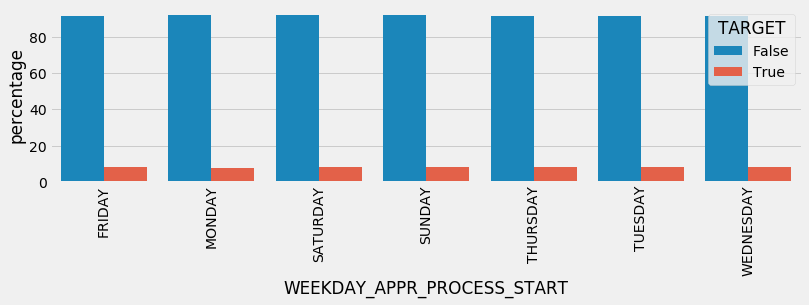

Group summary
    WEEKDAY_APPR_PROCESS_START  TARGET  percentage
0                      FRIDAY   False   91.853073
1                      FRIDAY    True    8.146927
2                      MONDAY   False   92.242773
3                      MONDAY    True    7.757227
4                    SATURDAY   False   92.112726
5                    SATURDAY    True    7.887274
6                      SUNDAY   False   92.070947
7                      SUNDAY    True    7.929053
8                    THURSDAY   False   91.899745
9                    THURSDAY    True    8.100255
10                    TUESDAY   False   91.649506
11                    TUESDAY    True    8.350494
12                  WEDNESDAY   False   91.839643
13                  WEDNESDAY    True    8.160357


In [103]:
var_obj = obj.columns
var_n = var_obj[10]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.rcParams['figure.figsize'] = 6,3
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

#dropping the column
train = train.drop(columns=['WEEKDAY_APPR_PROCESS_START'])
test = test.drop(columns=['WEEKDAY_APPR_PROCESS_START'])

It should not matter which day of the week the processing starts. We should get rid of it.

### Variable: ORGANIZATION_TYPE

Categorical variable name: ORGANIZATION_TYPE
% missing value 0.0


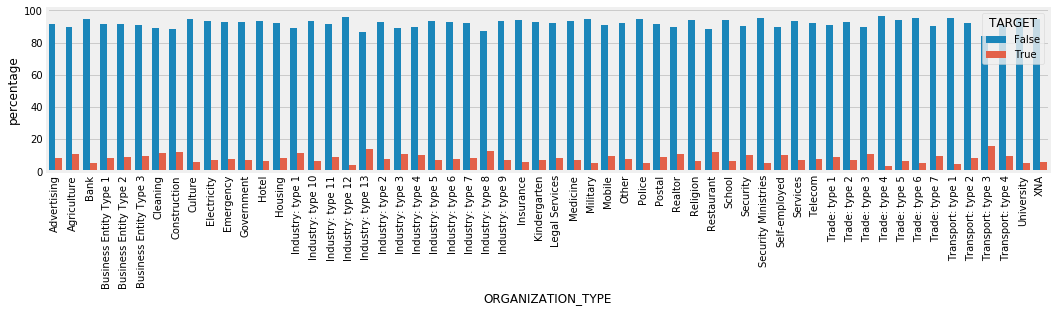

Group summary
           ORGANIZATION_TYPE  TARGET  percentage
115                     XNA    True    5.399646
61                 Medicine    True    6.584472
99            Trade: type 5    True    6.122449
33        Industry: type 11    True    8.653846
67                    Other    True    7.642510
35        Industry: type 12    True    3.794038
97            Trade: type 4    True    3.125000
37        Industry: type 13    True   13.432836
77               Restaurant    True   11.706240
39         Industry: type 2    True    7.205240
41         Industry: type 3    True   10.616229
95            Trade: type 3    True   10.337915
83      Security Ministries    True    4.863222
43         Industry: type 4    True   10.148233
93            Trade: type 2    True    7.000000
45         Industry: type 5    True    6.844741
65                   Mobile    True    9.148265
47         Industry: type 6    True    7.142857
91            Trade: type 1    True    8.908046
49         Industry: type

In [263]:
var_obj = obj.columns
var_n = var_obj[11]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
plt.rcParams['figure.figsize'] = 16,3
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var.sort_values(by='TARGET', ascending=False))

### Variable: FONDKAPREMONT_MODE

People with several organization type had difficulties in repaying loan

Categorical variable name: FONDKAPREMONT_MODE
% missing value 68.38617155158677


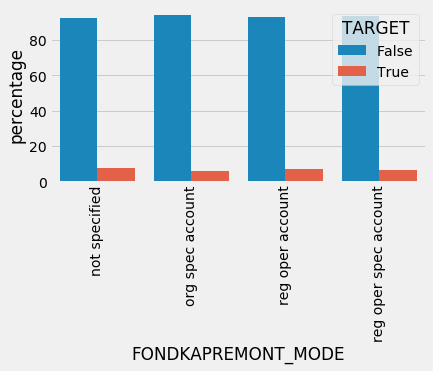

Group summary
       FONDKAPREMONT_MODE  TARGET  percentage
0          not specified   False   92.456480
1          not specified    True    7.543520
2       org spec account   False   94.180459
3       org spec account    True    5.819541
4       reg oper account   False   93.021807
5       reg oper account    True    6.978193
6  reg oper spec account   False   93.443709
7  reg oper spec account    True    6.556291
category
[reg oper account, NaN, org spec account, reg oper spec account, not specified]
Categories (4, object): [reg oper account, org spec account, reg oper spec account, not specified]


ValueError: fill value must be in categories

In [104]:
var_obj = obj.columns
var_n = var_obj[12]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
plt.rcParams['figure.figsize'] = 6,3
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

# dealing with missing values
table = train
var = 'FONDKAPREMONT_MODE'
print(table[var].dtype)
print(table[var].unique()) # unique value type
table[var] = table[var].fillna('missing')
test[var] = test[var].fillna('missing')

### Variable: HOUSETYPE_MODE

Categorical variable name: HOUSETYPE_MODE
% missing value 50.176091261776


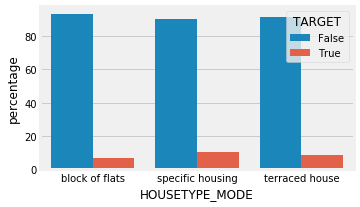

Group summary
      HOUSETYPE_MODE  TARGET  percentage
0    block of flats   False   93.056617
1    block of flats    True    6.943383
2  specific housing   False   89.859907
3  specific housing    True   10.140093
4    terraced house   False   91.501650
5    terraced house    True    8.498350


In [265]:
var_obj = obj.columns
var_n = var_obj[13]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
plt.rcParams['figure.figsize'] = 5,3
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
#plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

# dealing with missing values
table = train
var = 'HOUSETYPE_MODE'
print(table[var].dtype)
print(table[var].unique()) # unique value type
table[var] = table[var].fillna('missing')
test[var] = test[var].fillna('missing')

### Variable: WALLSMATERIAL_MODE

Categorical variable name: WALLSMATERIAL_MODE
% missing value 50.8407829313423


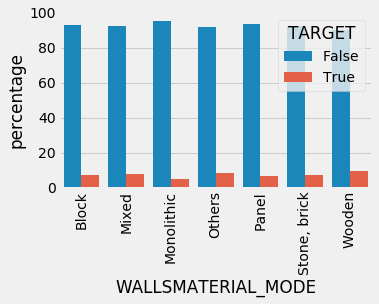

Group summary
    WALLSMATERIAL_MODE  TARGET  percentage
0               Block   False   92.975251
1               Block    True    7.024749
2               Mixed   False   92.465157
3               Mixed    True    7.534843
4          Monolithic   False   95.278246
5          Monolithic    True    4.721754
6              Others   False   91.692308
7              Others    True    8.307692
8               Panel   False   93.652332
9               Panel    True    6.347668
10       Stone, brick   False   92.594307
11       Stone, brick    True    7.405693
12             Wooden   False   90.302126
13             Wooden    True    9.697874
category
[Stone, brick, Block, NaN, Panel, Mixed, Wooden, Others, Monolithic]
Categories (7, object): [Stone, brick, Block, Panel, Mixed, Wooden, Others, Monolithic]


ValueError: fill value must be in categories

In [105]:
var_obj = obj.columns
var_n = var_obj[14]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
plt.rcParams['figure.figsize'] = 5,3
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

# dealing with missing values
table = train
var = 'WALLSMATERIAL_MODE'
print(table[var].dtype)
print(table[var].unique()) # unique value type
table[var] = table[var].fillna('missing')
test[var] = test[var].fillna('missing')

### Variable: EMERGENCYSTATE_MODE

Categorical variable name: EMERGENCYSTATE_MODE
% missing value 47.39830445089769


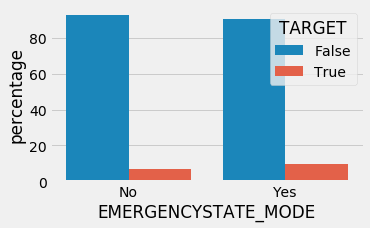

Group summary
   EMERGENCYSTATE_MODE  TARGET  percentage
0                  No   False   93.035100
1                  No    True    6.964900
2                 Yes   False   90.420962
3                 Yes    True    9.579038
category
[No, NaN, Yes]
Categories (2, object): [No, Yes]


ValueError: fill value must be in categories

In [106]:
# EMERGENCYSTATE_MODE: normalized information of the living area
var_obj = obj.columns
var_n = var_obj[15]
print('Categorical variable name:', var_n)
# % missing value
print('% missing value', train[var_n].isnull().sum()/len(train[var_n])* 100)
# distribution/frequency
df = pd.concat([train[var_n], train.TARGET], axis=1)
var= df.groupby([var_n])['TARGET'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values([var_n])
plt.rcParams['figure.figsize'] = 5,3
sns.barplot(x=var_n, y='percentage', hue='TARGET', data=var)
#plt.xticks(rotation='vertical')
plt.show()
print('Group summary\n', var)

# dealing with missing values
table = train
var = 'EMERGENCYSTATE_MODE'
print(table[var].dtype)
print(table[var].unique()) # unique value type
table[var] = table[var].fillna('missing')
test[var] = test[var].fillna('missing')

Among all these variables EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_ID_PUBLISH, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_HOUSING_TYPE, OCCUPATION_TYPE, ORGANIZATION_TYPE have visible influence on the TARGET. So, these variables are important in predicting the target.

### Correlation with target

In [77]:
# find correlation of the features with target
correlations =  train.corr()['TARGET'].sort_values()
print('Most negative correlations:\n', correlations.head(10), '\n\nMost positive correlations\n', correlations.tail(10))

Most negative correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED                          -0.044932
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
Name: TARGET, dtype: float64 

Most positive correlations
 NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                              

The correlation of any individual variable with the target is not strong. DAYS_BIRTH has strongest positive relation and EXIT_SOURCE_3 has maximum negative correlation. However, if we apply feature engineering the correlation canbe improved.

## Tranforming and reshaping categorical variables

Label encoding and One-hot encoding
For categorical variables with unique categories = 2, we will use label encoding, and with unique categories > 2, we will use one-hot encoding. The underlying assumption is keep it the values in one column when unique values = 2. Thus the number of column is same here.

In [107]:
print(train.shape, test.shape)

(307511, 97) (48744, 96)


In [132]:
# # fitting and transforming with label encoder
categorical = train.select_dtypes('category')
le = LabelEncoder()
le_count = 0
for col in categorical:
    
    if len(list(train[col].unique())) <= 2: # for unique category less/equal 2
        le.fit(train[col]) # fitting and transforming with label encoder
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        le_count += 1
print(le_count)

3


In [131]:
#categorical = pd.get_dummies(df.select_dtypes('category'))
categorical = train.select_dtypes('category')
categorical.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [133]:
## One hot encoding for unique category >2
train = pd.get_dummies(train.select_dtypes('category'))
test = pd.get_dummies(test.select_dtypes('category'))
print(train.shape, test.shape)

(307511, 127) (48744, 124)


## Table: Bureau

In [200]:
bureau = pd.read_csv(path + files[2])
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


## Variable type

In [472]:
print('Variable types are:\n', bureau.dtypes.value_counts())

Variable types are:
 float64    8
int64      6
object     3
dtype: int64


In [473]:
obj = bureau.select_dtypes('object') # selcting only categorical variable
obj_uni = obj.apply(pd.Series.nunique, axis=0) # unique values in category
print('\nUnique values in categorical variables are:\n', obj_uni.sort_values())


Unique values in categorical variables are:
 CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64


In [135]:
var_float = bureau.select_dtypes('float64')
print('\nVariables with float outcome:\n', var_float.columns)
var_int = bureau.select_dtypes('int64')
print('\nVariables with integer outcome:\n', var_int.columns)
var_int_uni = var_int.apply(pd.Series.nunique, axis=0)
print('\nUnique values in integer variables:', var_int_uni.sort_values())



Variables with float outcome:
 Index(['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY'],
      dtype='object')

Variables with integer outcome:
 Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'CNT_CREDIT_PROLONG', 'DAYS_CREDIT_UPDATE'],
      dtype='object')

Unique values in integer variables: CNT_CREDIT_PROLONG         10
CREDIT_DAY_OVERDUE        942
DAYS_CREDIT              2923
DAYS_CREDIT_UPDATE       2982
SK_ID_CURR             305811
SK_ID_BUREAU          1716428
dtype: int64


### Variable: DAYS_CREDIT_ENDDATE

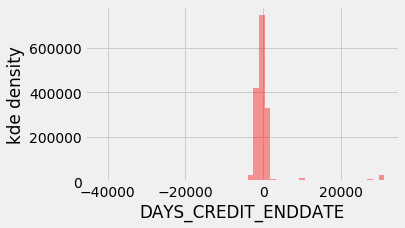

count    1.610875e+06
mean     5.105174e+02
std      4.994220e+03
min     -4.206000e+04
25%     -1.138000e+03
50%     -3.300000e+02
75%      4.740000e+02
max      3.119900e+04
Name: DAYS_CREDIT_ENDDATE, dtype: float64
7.186301369863013
18.43013698630137
2623.0
7.186301369863013


In [136]:
# any anomaly?
#var_s = 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'DAYS_CREDIT_UPDATE','DAYS_CREDIT_ENDDATE', 
#'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE','AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
#'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY', 
table = bureau
var = 'DAYS_CREDIT_ENDDATE'

# distribution of variable:
sns.distplot(table[var].dropna(), bins=50, kde=False, color='red')
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

print(table[var].describe())

# dealing with anomaly
print(bureau['DAYS_CREDIT_ENDDATE'].quantile(0.95)/365) # 95th percentile
print(bureau['DAYS_CREDIT_ENDDATE'].quantile(0.96)/365) # 96th percentile

# dealing with anomalies df.replace(0, 5)
threshold = bureau['DAYS_CREDIT_ENDDATE'].quantile(0.95)
print(threshold)
#bureau[bureau['DAYS_CREDIT_ENDDATE']>threshold]['DAYS_CREDIT_ENDDATE']
days = bureau['DAYS_CREDIT_ENDDATE']
for i in range(len(days)):
    if days[i] >= threshold:
        days[i]= threshold
        
print(days.quantile(0.97)/365) # 96th percentile
bureau['DAYS_CREDIT_ENDDATE'] = days

This variable Remaining duration of CB credit (in years here) at the time of application in Home Credit. There are anomalies in the days data since 75 years is a very high number. We will maintain the threshold at 95th percentaile.

## Missing values

In [11]:
# missing values
print('Total number of variables:', bureau.shape[1])
miss_val = bureau.isnull().sum() # number of missing value in each col
miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
miss_list = list(miss_val)
ind = miss_list.index(0)
miss_var = miss_val[0:ind] # only variables with missing values
print('Out of', bureau.shape[1], ', number of variables with missing values:', ind)

percent_miss = miss_var/len(bureau) * 100 # percent missing value for each variable
print('\n% data missing\n', percent_miss)    

Total number of variables: 17
Out of 17 , number of variables with missing values: 7

% data missing
 AMT_ANNUITY               71.473490
AMT_CREDIT_MAX_OVERDUE    65.513264
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_DEBT       15.011932
DAYS_CREDIT_ENDDATE        6.149573
AMT_CREDIT_SUM             0.000757
dtype: float64


In [137]:
# dealing with missing values
table = bureau
var = 'AMT_ANNUITY'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

% missing value 0.0


In [138]:
# dealing with missing values
table = bureau
var = 'AMT_CREDIT_MAX_OVERDUE'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

% missing value 0.0


In [139]:
# dealing with missing values
table = bureau
var = 'DAYS_ENDDATE_FACT'
table[var] = table[var].fillna(0) # max value
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

% missing value 0.0


In [140]:
# dealing with missing values
table = bureau
var = 'AMT_CREDIT_SUM_LIMIT'
table[var] = table[var].fillna(table[var].median())
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

% missing value 0.0


In [141]:
# dealing with missing values
table = bureau
var = 'AMT_CREDIT_SUM_DEBT'
table[var] = table[var].fillna(table[var].median())
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

% missing value 0.0


In [142]:
# dealing with missing values
table = bureau
var = 'DAYS_CREDIT_ENDDATE' # it has both missing values and anomalies
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

% missing value 0.0


In [143]:
# dealing with missing values
table = bureau
var = 'AMT_CREDIT_SUM' # it has both missing values and anomalies
table[var] = table[var].fillna(table[var].median())
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

% missing value 0.0


### Convert data type

In [144]:
convert_types(bureau, print_info=True)

Original Memory Usage: 0.23 gb.
New Memory Usage: 0.13 gb.


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,0.000000,0,9.132300e+04,0.000000e+00,0.000000,0.0,Consumer credit,-131,0.0
1,215354,5714463,Active,currency 1,-208,0,1075.0,0.0,0.000000,0,2.250000e+05,1.713420e+05,0.000000,0.0,Credit card,-20,0.0
2,215354,5714464,Active,currency 1,-203,0,528.0,0.0,0.000000,0,4.643235e+05,0.000000e+00,0.000000,0.0,Consumer credit,-16,0.0
3,215354,5714465,Active,currency 1,-203,0,0.0,0.0,0.000000,0,9.000000e+04,0.000000e+00,0.000000,0.0,Credit card,-16,0.0
4,215354,5714466,Active,currency 1,-629,0,1197.0,0.0,77674.500000,0,2.700000e+06,0.000000e+00,0.000000,0.0,Consumer credit,-21,0.0
5,215354,5714467,Active,currency 1,-273,0,2623.0,0.0,0.000000,0,1.800000e+05,7.101738e+04,108982.617188,0.0,Credit card,-31,0.0
6,215354,5714468,Active,currency 1,-43,0,79.0,0.0,0.000000,0,4.210380e+04,4.210380e+04,0.000000,0.0,Consumer credit,-22,0.0
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.000000,0,7.687845e+04,0.000000e+00,0.000000,0.0,Consumer credit,-1710,0.0
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.000000,0,1.030077e+05,0.000000e+00,0.000000,0.0,Consumer credit,-840,0.0
9,162297,5714471,Active,currency 1,-1146,0,-484.0,0.0,0.000000,0,4.500000e+03,0.000000e+00,0.000000,0.0,Credit card,-690,0.0


For a single SK_ID_CURR there are multiple entries suggesting people had multiple loans agaist their name. The unique ID is SK_ID_BUREAU. So first we need to groupby SK_ID_CURR.

### Merging with train data

In [145]:
#groupby SK_ID_CURR, count the number of previous loans as a new variable
prev_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
prev_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [159]:
train['SK_ID_CURR'] = id_train
test['SK_ID_CURR'] = id_test     

In [160]:
# Join prev_loan_counts to the training dataframe
train = train.merge(prev_loan_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(prev_loan_counts, on = 'SK_ID_CURR', how = 'left')
# Fill the missing values in previous laon counts with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
test['previous_loan_counts'] = test['previous_loan_counts'].fillna(0)
train.head()

,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SK_ID_CURR,previous_loan_counts
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,100002,8.0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,100003,4.0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,100004,2.0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,100006,0.0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,100007,1.0


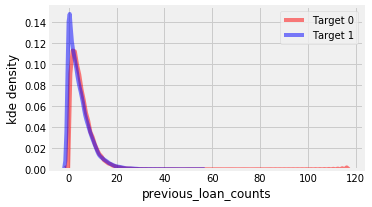

       AMT_CREDIT_TARGET_0  AMT_CREDIT_TARGET_1
count        282686.000000         24825.000000
mean              4.778464             4.613092
std               4.474586             4.732792
min               0.000000             0.000000
25%               1.000000             1.000000
50%               4.000000             3.000000
75%               7.000000             7.000000
max             116.000000            55.000000


In [283]:
var = 'previous_loan_counts'
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('AMT_CREDIT_TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('AMT_CREDIT_TARGET_1')
#print('Target 1:', target_1_des)
print(pd.concat([target_0_des, target_1_des], axis=1))


The number of previous loans does to matter much whether someone would default in repaying loan it seems. We can use the aggregate function in creating new variables.

### variable type: numeric

In [161]:
# Group by the client id, and calculate aggregation statistics
bureau = bureau.drop(columns = ['SK_ID_BUREAU']) # dropping 'SK_ID_BUREAU' column
bureau_num = bureau.select_dtypes(exclude='category') # excluding category type columns for aggregation purpose
bureau_agg = bureau_num.groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                 ...    DAYS_CREDIT_UPDATE                               \
  mean max min   ...                 count        mean  max   min   sum   
0  0.0   0   0   ...                     7  -93.142857   -6  -155  -652   
1  0.0   0   0   ...                     8 -499.875000   -7 -1185 -3999   
2  0.0   0   0   ...                     4 -816.000000  -43 -2131 -3264   
3  0.0   0   0   ...                     2 -532.000000 -382  -682 -1064   
4  0.0   0   0   ...                     3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357178  10822.5  0.0  24817.5  
1           8     0.000000      0.0  0.0      0.0  
2           4     0.000000      0.0  0.0      0.0  
3           2     0.000000      0.0  0.0      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

We have aggregated variables in 2 levels, which we need to collapse in single level column name.

In [162]:
columns = ['SK_ID_CURR']
variables = bureau_agg.columns.levels[0] # ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', etc.
add_stat = bureau_agg.columns.levels[1] # ['count', 'mean', 'max', 'min', 'sum']
for var in variables:
    if var != 'SK_ID_CURR':
        #print(var)
        for stat in add_stat[:-1]:
            columns.append('bureau_%s_%s' % (var, stat)) # column name added with table name and aggregation funciton
            #print(columns)
print(len(columns))
bureau_agg.columns = columns
bureau_agg.head()

61


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357178,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,8,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,4,0.000000,0.0,0.0,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,2,0.000000,0.0,0.0,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


We have 60 new variables which we will add to train 

In [306]:
bureau_agg_h = bureau_agg.head(20)
filepath1 = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/bureau_columns.csv"
bureau_agg_h.to_csv(filepath1, header='variable', index=True, index_label='#')

In [163]:
print('bureau table shape:', bureau_agg.shape)
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
#train = train.loc[:,~train.columns.duplicated()]
print('Training data shape:', train.shape, test.shape)
train.head()

bureau table shape: (305811, 61)
Training data shape: (307511, 189) (48744, 186)


,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,0,1,0,0,0,0,0,0,0,1,...,8.0,-499.875,-7.0,-1185.0,-3999.0,8.0,0.0,0.0,0.0,0.0
1,1,0,0,0,1,0,0,0,0,0,...,4.0,-816.000,-43.0,-2131.0,-3264.0,4.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,0,0,0,1,...,2.0,-532.000,-382.0,-682.0,-1064.0,2.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,0,0,0,0,0,0,0,1,...,1.0,-783.000,-783.0,-783.0,-783.0,1.0,0.0,0.0,0.0,0.0


### Correlation with target

In [178]:
# List of new correlations
new_corrs = []

for col in columns[1:]:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    new_corrs.append((col, corr))
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998122),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.07798968857874382),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.07033710863207139),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968668),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.06797336688337806),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.06446744636023409),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973095),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111589),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.04404704429669296),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730176),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484684),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306004),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03632474429814861),
 ('bureau_DAYS_CREDIT_UPDATE_max', 0.028233546896535826)]

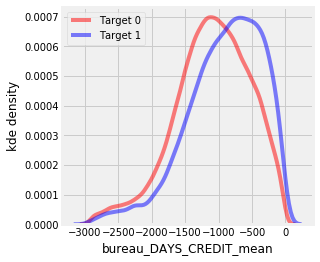

            TARGET_0      TARGET_1
count  243123.000000  20368.000000
mean    -1097.677429   -908.412036
std       561.419326    556.700978
min     -2922.000000  -2922.000000
25%     -1446.500000  -1247.281250
50%     -1067.000000   -835.333333
75%      -683.126984   -476.958333
max         0.000000     -4.000000


In [292]:
var = 'bureau_DAYS_CREDIT_mean'
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
print(pd.concat([target_0_des, target_1_des], axis=1))

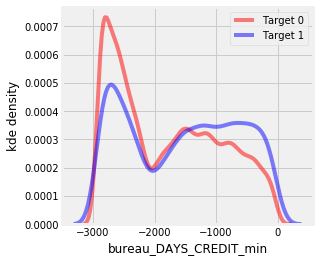

            TARGET_0      TARGET_1
count  243123.000000  20368.000000
mean    -1781.189752  -1537.790848
std       858.405931    896.550237
min     -2922.000000  -2922.000000
25%     -2591.000000  -2441.000000
50%     -1861.000000  -1469.000000
75%     -1063.000000   -748.000000
max         0.000000     -4.000000


In [299]:
# bureau_DAYS_CREDIT_min
var = 'bureau_DAYS_CREDIT_min'
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
print(pd.concat([target_0_des, target_1_des], axis=1))

### Variable type: Categorical 
Dealing with categorical variables.

In [313]:
bureau.select_dtypes('category').head()

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
0,Closed,currency 1,Consumer credit
1,Active,currency 1,Credit card
2,Active,currency 1,Consumer credit
3,Active,currency 1,Credit card
4,Active,currency 1,Consumer credit


In [179]:
categorical = pd.get_dummies(bureau.select_dtypes('category'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()


,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [180]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1      ...  CREDIT_TYPE_Microloan       \
                                  sum mean ...                    sum mean   
SK_ID_CURR                                 ...                               
100001                              7  1.0 ...                      0  0.0   
100002                              8  1.0 ...                      0  0.0   
100003                              4  1.0 ...                      0  0.0   
100004                              2  1.0 ...                      0  0.0   
100005                              3  1.0 ...                      0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

 Again multilevel columns are generated which we need to collapse. For categorical variables sum means count of that category, and mean is the normalized count.

In [181]:
variables = categorical_grouped.columns.levels[0] # ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', etc.
add_stat = ['count', 'count_norm']

group_var = 'SK_ID_CURR'
columns = []

# Iterate through the variables names
for var in variables:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in add_stat:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [183]:
categorical_grouped.reset_index(inplace=True)

In [184]:
categorical_grouped.head()

,SK_ID_CURR,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
2,100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
3,100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
4,100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [185]:
# merge with train data
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
test = test.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,0,1,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
1,1,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.125
2,0,1,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
3,1,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
4,0,1,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000


### Correlation with Target

In [319]:
# List of new correlations
new_corrs = []

for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    new_corrs.append((col, corr))
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('CREDIT_ACTIVE_Closed_count_norm', -0.0793688740888962),
 ('CREDIT_ACTIVE_Active_count_norm', 0.0773557795854437),
 ('CREDIT_ACTIVE_Active_count', 0.06712815345642874),
 ('CREDIT_TYPE_Microloan_count_norm', 0.04443943809087858),
 ('CREDIT_TYPE_Credit card_count', 0.034817819905382213),
 ('CREDIT_TYPE_Credit card_count_norm', 0.03468405774232269),
 ('CREDIT_TYPE_Microloan_count', 0.034110498274215695),
 ('CREDIT_ACTIVE_Closed_count', -0.030812408184358753),
 ('CREDIT_TYPE_Consumer credit_count_norm', -0.026258496023451722),
 ('CREDIT_TYPE_Mortgage_count', -0.023306648977252636),
 ('CREDIT_TYPE_Mortgage_count_norm', -0.02086745745636145),
 ('CREDIT_TYPE_Car loan_count', -0.020816695387449097),
 ('CREDIT_TYPE_Car loan_count_norm', -0.020134386805691875),
 ('CREDIT_ACTIVE_Sold_count_norm', 0.016530032076332024),
 ('CREDIT_ACTIVE_Sold_count', 0.012057565591670006)]

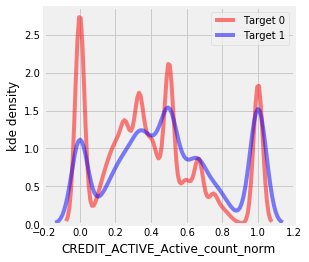

            TARGET_0      TARGET_1
count  243123.000000  20368.000000
mean        0.406067      0.495395
std         0.306644      0.317295
min         0.000000      0.000000
25%         0.181818      0.266667
50%         0.363636      0.500000
75%         0.571429      0.700000
max         1.000000      1.000000


In [321]:
# bureau_DAYS_CREDIT_min
var = 'CREDIT_ACTIVE_Active_count_norm'
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
print(pd.concat([target_0_des, target_1_des], axis=1))

In [323]:
categorical_grouped_h = categorical_grouped.head(20)
filepath1 = "C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/bureau_cat_columns.csv"
categorical_grouped_h.to_csv(filepath1, header='variable', index=True, index_label='#')

In [186]:
dir()

['A',
 'B',
 'In',
 'LabelEncoder',
 'Out',
 '_',
 '_125',
 '_126',
 '_128',
 '_130',
 '_131',
 '_134',
 '_144',
 '_145',
 '_147',
 '_149',
 '_15',
 '_150',
 '_152',
 '_153',
 '_155',
 '_158',
 '_160',
 '_161',
 '_162',
 '_163',
 '_169',
 '_17',
 '_170',
 '_171',
 '_175',
 '_177',
 '_178',
 '_179',
 '_180',
 '_181',
 '_182',
 '_184',
 '_185',
 '_19',
 '_20',
 '_21',
 '_23',
 '_24',
 '_25',
 '_26',
 '_27',
 '_28',
 '_29',
 '_30',
 '_31',
 '_32',
 '_33',
 '_34',
 '_35',
 '_36',
 '_37',
 '_38',
 '_39',
 '_40',
 '_41',
 '_42',
 '_43',
 '_44',
 '_45',
 '_46',
 '_47',
 '_48',
 '_49',
 '_50',
 '_51',
 '_52',
 '_53',
 '_54',
 '_55',
 '_56',
 '_57',
 '_58',
 '_59',
 '_60',
 '_61',
 '_62',
 '_63',
 '_64',
 '_65',
 '_66',
 '_67',
 '_68',
 '_69',
 '_70',
 '_71',
 '_72',
 '_73',
 '_74',
 '_75',
 '_8',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i100',
 '_i101',
 '_i102',
 '_i103',
 '_i

In [187]:
# manage memory
# Remove variables to free memory
#dir()
gc.enable()
del bureau_agg, bureau_num, categorical, categorical_grouped, group_var, days
gc.collect()



5150

These correlations with categorical variables are really weak.

## Table: bureau Balance
from default risk_ bureau

In [188]:
bureau_bal = pd.read_csv(path + files[3])
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## Variable type

In [389]:
print('Variable types are:\n', bureau_bal.dtypes.value_counts()) # variable type: integer, float, categorical

Variable types are:
 int64     2
object    1
dtype: int64


## Missing value

In [189]:
# missing values
df = bureau_bal
print('Total number of variables:', df.shape[1])
miss_val = df.isnull().sum() # number of missing value in each col
miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
miss_list = list(miss_val)
ind = miss_list.index(0)
miss_var = miss_val[0:ind] # only variables with missing values
print('Out of', df.shape[1], ', number of variables with missing values:', ind)

percent_miss = miss_var/len(df) * 100 # percent missing value for each variable
print('\n% data missing\n', percent_miss)    

Total number of variables: 3
Out of 3 , number of variables with missing values: 0

% data missing
 Series([], dtype: float64)


### Convert data type

In [190]:
convert_types(bureau_bal, print_info=True)

Original Memory Usage: 0.66 gb.
New Memory Usage: 0.35 gb.


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


For each SK_ID_BUREAU there are multiple records and corresponding status. We first group by SK_ID_BUREAU (each loan) and then for each client (SK_ID_CURR).

### Merging with train

In [191]:
def count_categorical(df, group_var, df_name):
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [192]:
# for categorical variable: STATUS
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_bal, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
#bureau_balance_counts = bureau_balance_counts.reset_index(inplace=True)
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [193]:
bureau_balance_counts.reset_index(inplace=True)

In [194]:
bureau_balance_counts.head()

,SK_ID_BUREAU,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
0,5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
1,5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
2,5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
3,5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
4,5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [195]:
# for numeric variables
def agg_numeric(df, group_var, df_name):
   
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [196]:
## numeric column MONTH_BALANCE
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_bal, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [197]:
# merging bureau_balance_agg and bureau_balance_count
bureau_by_loan_ = bureau_balance_agg.merge(bureau_balance_counts, on = 'SK_ID_BUREAU', how = 'outer')


In [198]:
bureau_by_loan_.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


Now we need to include SK_ID_BUREAU and SK_ID_CURR from bureau to merge with train using SK_ID_CURR.

In [201]:
bureau_by_loan = bureau_by_loan_.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [202]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


In [206]:
train['SK_ID_CURR'] = id_train
test['SK_ID_CURR'] = id_test

In [207]:
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
print('Training data shape:', train.shape, test.shape)
train.head()

Training data shape: (307511, 343) (48744, 339)


,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,0,1,0,0,0,0,0,0,0,1,...,8.0,1.875,3.0,0.0,15.0,8.0,0.161932,0.5,0.0,1.295455
1,1,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Correlation with target

In [404]:
columns = bureau_balance_by_client.columns
columns

Index(['SK_ID_CURR', 'client_bureau_balance_MONTHS_BALANCE_count_count',
       'client_bureau_balance_MONTHS_BALANCE_count_mean',
       'client_bureau_balance_MONTHS_BALANCE_count_max',
       'client_bureau_balance_MONTHS_BALANCE_count_min',
       'client_bureau_balance_MONTHS_BALANCE_count_sum',
       'client_bureau_balance_MONTHS_BALANCE_mean_count',
       'client_bureau_balance_MONTHS_BALANCE_mean_mean',
       'client_bureau_balance_MONTHS_BALANCE_mean_max',
       'client_bureau_balance_MONTHS_BALANCE_mean_min',
       ...
       'client_bureau_balance_STATUS_X_count_count',
       'client_bureau_balance_STATUS_X_count_mean',
       'client_bureau_balance_STATUS_X_count_max',
       'client_bureau_balance_STATUS_X_count_min',
       'client_bureau_balance_STATUS_X_count_sum',
       'client_bureau_balance_STATUS_X_count_norm_count',
       'client_bureau_balance_STATUS_X_count_norm_mean',
       'client_bureau_balance_STATUS_X_count_norm_max',
       'client_bureau_balance_S

In [208]:
# List of new correlations
new_corrs = []

for col in columns[1:]:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    new_corrs.append((col, corr))
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('CREDIT_CURRENCY_currency 1_count', -0.005447723989403462),
 ('CREDIT_TYPE_Credit card_count', -0.0048425522253828495),
 ('CREDIT_ACTIVE_Closed_count', -0.004106829606529608),
 ('CREDIT_ACTIVE_Sold_count', -0.002821845379854199),
 ('CREDIT_TYPE_Interbank credit_count', nan),
 ('CREDIT_TYPE_Interbank credit_count_norm', nan),
 ('CREDIT_TYPE_Mobile operator loan_count', nan),
 ('CREDIT_TYPE_Mobile operator loan_count_norm', nan),
 ('CREDIT_TYPE_Mortgage_count', -0.004581268145414179),
 ('CREDIT_TYPE_Consumer credit_count', -0.004406219318823181),
 ('CREDIT_TYPE_Mortgage_count_norm', -0.0028178851817919387),
 ('CREDIT_TYPE_Another type of loan_count', -0.0026400832565663074),
 ('CREDIT_CURRENCY_currency 3_count_norm', -0.0023994528692282847),
 ('CREDIT_TYPE_Unknown type of loan_count', -0.0020740018107188295),
 ('CREDIT_CURRENCY_currency 4_count', -0.0019969412820523636)]

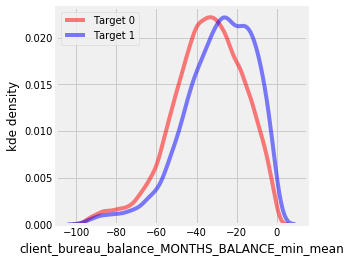

           TARGET_0     TARGET_1
count  84721.000000  7510.000000
mean     -34.695690   -28.895740
std       17.764441    17.519027
min      -96.000000   -95.000000
25%      -45.666667   -39.500000
50%      -33.666667   -27.000000
75%      -21.714286   -15.333333
max        0.000000     0.000000


In [414]:
# bureau_DAYS_CREDIT_min
var = 'client_bureau_balance_MONTHS_BALANCE_min_mean'
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
print(pd.concat([target_0_des, target_1_des], axis=1))

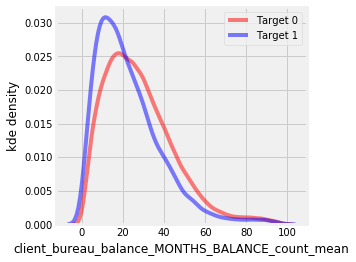

           TARGET_0     TARGET_1
count  84721.000000  7510.000000
mean      27.879011    22.944792
std       16.847241    15.918697
min        1.000000     1.000000
25%       15.166667    11.000000
50%       25.142857    19.333333
75%       37.375000    31.000000
max       97.000000    96.000000


In [415]:
# bureau_DAYS_CREDIT_min
var = 'client_bureau_balance_MONTHS_BALANCE_count_mean'
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 'Target 0', color='red', alpha=0.5)
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'Target 1', color='blue', alpha=0.5)
plt.xlabel(var)
plt.ylabel('kde density')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

# Statistical summary
# with target '0'
target_0_des = train.loc[train['TARGET'] == 0, var].describe().rename('TARGET_0')
#print('Target 0:', target_0_des)
# with target '1'
target_1_des = train.loc[train['TARGET'] == 1, var].describe().rename('TARGET_1')
#print('Target 1:', target_1_des)
print(pd.concat([target_0_des, target_1_des], axis=1))

As we are going to in similar way with other tables as well. We will create functions for repeated use.

## Table: Previous

In [209]:
previous = pd.read_csv(path + files[8])
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.19 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


### Missing Values

In [210]:
# missing values
df = previous
print('Total number of variables:', df.shape[1])
miss_val = df.isnull().sum() # number of missing value in each col
miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
miss_list = list(miss_val)
ind = miss_list.index(0)
miss_var = miss_val[0:ind] # only variables with missing values
print('Out of', df.shape[1], ', number of variables with missing values:', ind)

percent_miss = miss_var/len(df) * 100 # percent missing value for each variable
print('\n% data missing\n', percent_miss)    

Total number of variables: 37
Out of 37 , number of variables with missing values: 16

% data missing
 RATE_INTEREST_PRIVILEGED     99.643698
RATE_INTEREST_PRIMARY        99.643698
RATE_DOWN_PAYMENT            53.636480
AMT_DOWN_PAYMENT             53.636480
NAME_TYPE_SUITE              49.119754
DAYS_TERMINATION             40.298129
NFLAG_INSURED_ON_APPROVAL    40.298129
DAYS_FIRST_DRAWING           40.298129
DAYS_FIRST_DUE               40.298129
DAYS_LAST_DUE_1ST_VERSION    40.298129
DAYS_LAST_DUE                40.298129
AMT_GOODS_PRICE              23.081773
AMT_ANNUITY                  22.286665
CNT_PAYMENT                  22.286366
PRODUCT_COMBINATION           0.020716
AMT_CREDIT                    0.000060
dtype: float64


In [211]:
# dealing with missing values
#dropping the column 
previous = previous.drop(columns=['RATE_INTEREST_PRIVILEGED'])

In [212]:
# dealing with missing values
#dropping the column 
previous = previous.drop(columns=['RATE_INTEREST_PRIMARY'])

In [213]:
# dealing with missing values: this variable is not important
#dropping the column 
previous = previous.drop(columns=['WEEKDAY_APPR_PROCESS_START'])

In [214]:
# dealing with missing values
table = previous
var = 'RATE_DOWN_PAYMENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

% missing value 0.0


In [215]:
# dealing with missing values
table = previous
var = 'AMT_DOWN_PAYMENT'
print(table[var].dtype)
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

float32
% missing value 0.0


In [216]:
# dealing with missing values
table = previous
var = 'NAME_TYPE_SUITE'
print(table[var].dtype)
table[var] = table[var].fillna('Unaccompanied')
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

category
% missing value 0.0


In [217]:
# dealing with missing values
table = previous
var = 'NFLAG_INSURED_ON_APPROVAL'
print(table[var].dtype)

print('% missing value', table[var].isnull().sum()/len(table[var])* 100)
print(table[var].unique()) # unique value type
table[var] = table[var].fillna(-1) # creating new category

float32
% missing value 40.29812946125467
[ 0.  1. nan]


In [218]:
# dealing with missing values
table = previous
var = 'AMT_GOODS_PRICE'
print(table[var].dtype)
print(table[var].unique()) # unique value type
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

float32
[ 17145.      607500.      112500.      ... 332596.09375 373230.71875
 267295.5    ]
% missing value 0.0


In [219]:
# dealing with missing values
table = previous
var = 'AMT_ANNUITY'
print(table[var].dtype)
print(table[var].unique()) # unique value type
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

float32
[ 1730.43005371 25188.61523438 15060.73535156 ... 15708.15039062
  8546.94042969 14704.29003906]
% missing value 0.0


In [220]:
# dealing with missing values
table = previous
var = 'CNT_PAYMENT'
print(table[var].dtype)
print(table[var].unique()) # unique value type
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

float32
[12. 36. 24. 18. nan 54. 30.  8.  3.  6.  0. 48. 10. 60. 42.  4.  5. 16.
 20.  7. 14.  9. 22. 15. 11. 13. 17. 26. 23. 38. 33. 72. 59. 34. 84. 28.
 41. 66. 29. 32. 44. 39. 40. 46. 35. 19. 47. 45. 21. 53.]
% missing value 0.0


In [233]:
# dealing with missing values
table = previous
var = 'PRODUCT_COMBINATION'
print(table[var].dtype)
print(table[var].unique()) # unique value type
#table[var] = table[var].fillna('missing').astype('category') # creating new category#
#table[var] = table[var].fillna('missing')
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

category
[POS mobile with interest, Cash X-Sell: low, Cash X-Sell: high, Cash X-Sell: middle, Cash Street: high, ..., Cash Street: low, POS industry without interest, Cash Street: middle, POS others without interest, NaN]
Length: 18
Categories (17, object): [POS mobile with interest, Cash X-Sell: low, Cash X-Sell: high, Cash X-Sell: middle, ..., Cash Street: low, POS industry without interest, Cash Street: middle, POS others without interest]
% missing value 0.02071590826085759


In [231]:
# dealing with missing values
table = previous
var = 'AMT_CREDIT'
print(table[var].dtype)
print(table[var].unique()) # unique value type
#table[var] = table[var].fillna('missing').astype('category') # creating new category#
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

float32
[ 17145.      679671.      136444.5     ... 977724.      626796.
 436370.21875]
% missing value 0.0


### Anomaly + Missing values
#### DAYS_TERMINATION

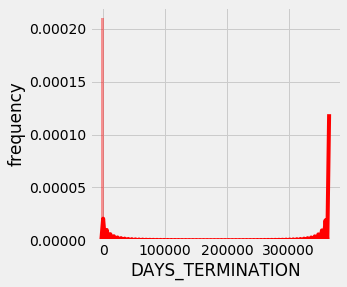

-2.0
365243.0
float32
[-3.700e+01 -2.000e+00 -1.770e+02 ... -2.828e+03 -2.870e+03 -2.815e+03]
% missing value 0.0


In [234]:
# Any anomaly?
# bureau_DAYS_CREDIT_min
table = previous
var = 'DAYS_TERMINATION'
sns.distplot(table[var].dropna(), bins=100, color='red')
plt.xlabel(var)
plt.ylabel('frequency')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

table[var].describe()

print(table[var].quantile(0.77344))
print(table[var].quantile(0.77345))

# dealing with anomalies
table[var] = table[var].replace(365243, -2)

# dealing with missing values
table = previous
var = 'DAYS_TERMINATION'
print(table[var].dtype)
print(table[var].unique()) # unique value type
#table[var] = table[var].fillna('missing').astype('category') # creating new category#
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)



This variable has both, missing values and anomalies. The variable describes relative to application date of current application when was the expected termination of the previous application. The anomalies are set to be 365243 days or ~ 1000 years. We will clip that to 77th percentile which is -2days. For missing values we would set 0.

#### Variable: DAYS_FIRST_DRAWING

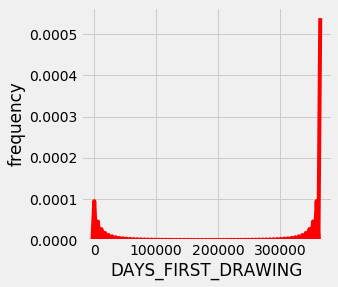

-159.0
365243.0


In [235]:
# dealing with missing values and anomalies          
table = previous
var = 'DAYS_FIRST_DRAWING'
sns.distplot(table[var].dropna(), bins=100, color='red')
plt.xlabel(var)
plt.ylabel('frequency')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()
table[var].describe()

print(table[var].quantile(0.06))
print(table[var].quantile(0.07))
#
previous = previous.drop(columns='DAYS_FIRST_DRAWING')

This variable describes relative to application date of current application when was the first disbursement of the previous application. 93% of the data has anomalies and so we will drop this variable. 

#### Variable: DAYS_FIRST_DUE

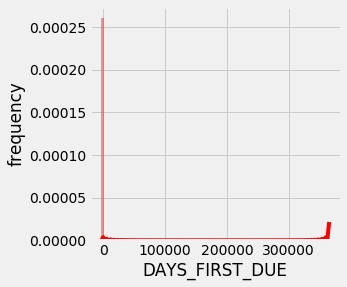

-2.0
365243.0


In [236]:
# variables with anomalies and missing values:
table = previous
var = 'DAYS_FIRST_DUE'
sns.distplot(table[var].dropna(), bins=100, color='red')
plt.xlabel(var)
plt.ylabel('frequency')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()
table[var].describe()

print(table[var].quantile(0.95923))
print(table[var].quantile(0.95924))

# dealing with anomalies
table[var] = table[var].replace(365243, -2)

#### Variable: DAYS_TERMINATION

float32
[-3.700e+01 -2.000e+00 -1.770e+02 ... -2.828e+03 -2.870e+03 -2.815e+03]
% missing value 0.0


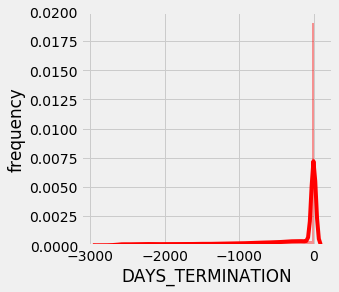

count    1.670214e+06
mean    -4.517652e+02
std      7.024451e+02
min     -2.874000e+03
25%     -6.950000e+02
50%     -2.000000e+00
75%      0.000000e+00
max      0.000000e+00
Name: DAYS_TERMINATION, dtype: float64

In [238]:
# dealing with missing values
table = previous
var = 'DAYS_TERMINATION'
print(table[var].dtype)
print(table[var].unique()) # unique value type
#table[var] = table[var].fillna('missing').astype('category') # creating new category#
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

sns.distplot(table[var], bins=100, color='red')
plt.xlabel(var)
plt.ylabel('frequency')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

table[var].describe()

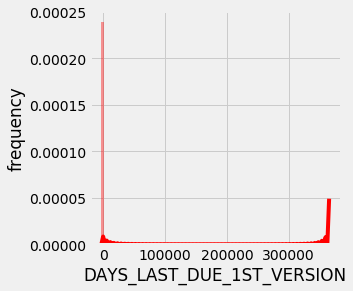

2233.9889560069423
365243.0
1656.0


In [239]:
# variables with anomalies and missing values:
table = previous
var = 'DAYS_LAST_DUE_1ST_VERSION'
sns.distplot(table[var].dropna(), bins=100, color='red')
plt.xlabel(var)
plt.ylabel('frequency')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()
table[var].describe()

print(table[var].quantile(0.905867))
print(table[var].quantile(0.9059))

table = previous
var = 'DAYS_LAST_DUE_1ST_VERSION'
table[var] = table[var].replace(365243, 2235)
print(table[var].quantile(0.905))

10% data has anomalies which we would clip to 2235.

#### Variable: DAYS_LAST_DUE_1ST_VERSION

float64
[ 300.  916.   59. ... 1878. 2016. 1760.]
% missing value 0.0


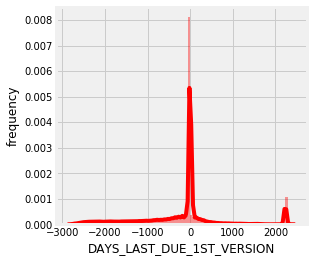

count    1.670214e+06
mean    -2.406163e+02
std      9.654839e+02
min     -2.801000e+03
25%     -5.800000e+02
50%      0.000000e+00
75%      0.000000e+00
max      2.389000e+03
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: float64

In [40]:
# dealing with missing values
table = previous
var = 'DAYS_LAST_DUE_1ST_VERSION'
print(table[var].dtype)
print(table[var].unique()) # unique value type
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)

sns.distplot(table[var].dropna(), bins=100, color='red')
plt.xlabel(var)
plt.ylabel('frequency')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()

table[var].describe()

#### Variable: DAYS_LAST_DUE

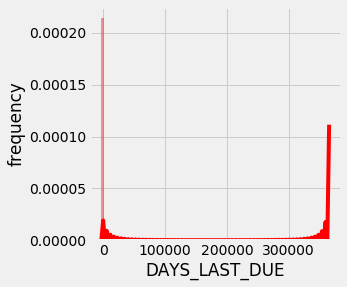

-2.0
365243.0
-2.0


In [240]:
               
# variables with anomalies and missing values:
table = previous
var = 'DAYS_LAST_DUE'
sns.distplot(table[var].dropna(), bins=100, color='red')
plt.xlabel(var)
plt.ylabel('frequency')
#plt.yscale('log')
plt.grid(True)
plt.rcParams['figure.figsize'] = 4,4
plt.show()
table[var].describe()

print(table[var].quantile(0.78817))
print(table[var].quantile(0.78818))

# dealing with anomalies
table[var] = table[var].replace(365243, -2)
print(table[var].quantile(0.8))

### Merging with train

We will depend on the sklearn model to deal with the missing values after merging

In [241]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 81)


,SK_ID_CURR,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_count,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_min,...,previous_DAYS_TERMINATION_count,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_sum,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000000,3951.000000,3951.000000,3951.000000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775391,9251.775391,9251.775391,9251.775391,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.988281,98356.992188,6737.310059,169661.968750,3,435436.50,900000.0,68809.5,...,3,-1047.333374,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250000,5357.250000,5357.250000,5357.250000,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,2,2406.600098,4813.200195,0.000000,4813.200195,2,22308.75,44617.5,0.0,...,2,-230.000000,0.0,-460.0,-460.0,2,-0.500000,0.0,-1.0,-1.0


In [242]:
def agg_categorical(df, parent_var, df_name):
       
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [243]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 271)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


In [244]:
previous_counts.reset_index(inplace=True)

#previous_agg.reset_index(inplace=True)
previous_agg.head()

,SK_ID_CURR,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_count,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_min,...,previous_DAYS_TERMINATION_count,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_sum,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000000,3951.000000,3951.000000,3951.000000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775391,9251.775391,9251.775391,9251.775391,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.988281,98356.992188,6737.310059,169661.968750,3,435436.50,900000.0,68809.5,...,3,-1047.333374,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250000,5357.250000,5357.250000,5357.250000,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,2,2406.600098,4813.200195,0.000000,4813.200195,2,22308.75,44617.5,0.0,...,2,-230.000000,0.0,-460.0,-460.0,2,-0.500000,0.0,-1.0,-1.0


In [246]:
# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')



In [247]:
print(train.shape, test.shape)

(307511, 694) (48744, 690)


### Correlation with target

In [249]:
columns = previous_agg.columns

In [250]:
# List of new correlations
new_corrs = []

for col in columns[1:]:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    new_corrs.append((col, corr))
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('previous_NFLAG_INSURED_ON_APPROVAL_sum', -0.05789768467218553),
 ('previous_DAYS_LAST_DUE_1ST_VERSION_sum', 0.056835487751343686),
 ('previous_DAYS_FIRST_DUE_mean', 0.05558918293415755),
 ('previous_DAYS_DECISION_min', 0.05343369406767517),
 ('previous_DAYS_LAST_DUE_1ST_VERSION_min', 0.05325268467664903),
 ('previous_DAYS_FIRST_DUE_min', 0.05316906511545081),
 ('previous_DAYS_LAST_DUE_min', 0.05262110280311805),
 ('previous_DAYS_TERMINATION_min', 0.051694663596146495),
 ('previous_NFLAG_INSURED_ON_APPROVAL_mean', -0.051641552280623886),
 ('previous_DAYS_TERMINATION_mean', 0.050621682045737075),
 ('previous_DAYS_LAST_DUE_1ST_VERSION_mean', 0.04797887468862437),
 ('previous_DAYS_DECISION_mean', 0.04686436759886143),
 ('previous_DAYS_LAST_DUE_sum', 0.04396796953429467),
 ('previous_DAYS_TERMINATION_sum', 0.04346733026966449),
 ('previous_DAYS_FIRST_DUE_sum', 0.0425020508048998)]

### Manage memory

In [252]:
dir()

['A',
 'B',
 'In',
 'LabelEncoder',
 'Out',
 '_',
 '_125',
 '_126',
 '_128',
 '_130',
 '_131',
 '_134',
 '_144',
 '_145',
 '_147',
 '_149',
 '_15',
 '_150',
 '_152',
 '_153',
 '_155',
 '_158',
 '_160',
 '_161',
 '_162',
 '_163',
 '_169',
 '_17',
 '_170',
 '_171',
 '_175',
 '_177',
 '_178',
 '_179',
 '_180',
 '_181',
 '_182',
 '_184',
 '_185',
 '_186',
 '_187',
 '_188',
 '_19',
 '_190',
 '_192',
 '_194',
 '_196',
 '_198',
 '_20',
 '_200',
 '_201',
 '_202',
 '_205',
 '_207',
 '_208',
 '_209',
 '_21',
 '_23',
 '_237',
 '_238',
 '_24',
 '_241',
 '_243',
 '_244',
 '_245',
 '_248',
 '_25',
 '_250',
 '_26',
 '_27',
 '_28',
 '_29',
 '_30',
 '_31',
 '_32',
 '_33',
 '_34',
 '_35',
 '_36',
 '_37',
 '_38',
 '_39',
 '_40',
 '_41',
 '_42',
 '_43',
 '_44',
 '_45',
 '_46',
 '_47',
 '_48',
 '_49',
 '_50',
 '_51',
 '_52',
 '_53',
 '_54',
 '_55',
 '_56',
 '_57',
 '_58',
 '_59',
 '_60',
 '_61',
 '_62',
 '_63',
 '_64',
 '_65',
 '_66',
 '_67',
 '_68',
 '_69',
 '_70',
 '_71',
 '_72',
 '_73',
 '_74',
 '_75',


In [253]:
# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()


3582

## Table: Cash

In [254]:
cash = pd.read_csv(path + files[7])
cash = convert_types(cash, print_info=True)
cash.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.41 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


### Missing Values

In [255]:
# missing values
df = cash
print('Total number of variables:', df.shape[1])
miss_val = df.isnull().sum() # number of missing value in each col
miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
miss_list = list(miss_val)
ind = miss_list.index(0)
miss_var = miss_val[0:ind] # only variables with missing values
print('Out of', df.shape[1], ', number of variables with missing values:', ind)

percent_miss = miss_var/len(df) * 100 # percent missing value for each variable
print('\n% data missing\n', percent_miss)    

Total number of variables: 8
Out of 8 , number of variables with missing values: 2

% data missing
 CNT_INSTALMENT_FUTURE    0.260835
CNT_INSTALMENT           0.260675
dtype: float64


In [256]:
# missing values #table[var] = table[var].fillna(table[var].median())
table = cash
var = 'CNT_INSTALMENT_FUTURE'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


In [257]:
# missing values #table[var] = table[var].fillna(table[var].median())
table = cash
var = 'CNT_INSTALMENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


### Merging with train table

In [258]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids
    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg


In [259]:
def aggregate_client(df, group_vars, df_names):
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    df_agg.reset_index(inplace=True)
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])
        df_counts.reset_index(inplace=True)

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [260]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()
#cash_by_client.reset_index(inplace=True)

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_SK_DPD_max_sum,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28,28,28.0,32.0,36.0,36.0,36.0,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,0,0,456.0,361.0,456.0,456.0,456.0,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,0,0,288.0,256.0,248.0,283.0,288.0,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,0,0,16.0,12.0,12.0,15.0,16.0,16,36.0,60.0
100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,0,0,132.0,99.0,0.0,117.0,132.0,121,792.0,1287.0


In [261]:
cash_by_client.reset_index(inplace=True)

In [262]:
cash_by_client.head()

,SK_ID_CURR,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,...,client_cash_SK_DPD_max_sum,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
0,100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,...,28,28,28.0,32.0,36.0,36.0,36.0,41,62.0,164.0
1,100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,...,0,0,456.0,361.0,456.0,456.0,456.0,361,5415.0,8664.0
2,100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,...,0,0,288.0,256.0,248.0,283.0,288.0,272,1608.0,2840.0
3,100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,...,0,0,16.0,12.0,12.0,15.0,16.0,16,36.0,60.0
4,100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,...,0,0,132.0,99.0,0.0,117.0,132.0,121,792.0,1287.0


In [263]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
print(train.shape, test.shape)

Cash by Client Shape:  (337252, 157)
(307511, 850) (48744, 846)


### Correlation with Target

### Memory management

In [264]:
dir()

['A',
 'B',
 'In',
 'LabelEncoder',
 'Out',
 '_',
 '_125',
 '_126',
 '_128',
 '_130',
 '_131',
 '_134',
 '_144',
 '_145',
 '_147',
 '_149',
 '_15',
 '_150',
 '_152',
 '_153',
 '_155',
 '_158',
 '_160',
 '_161',
 '_162',
 '_163',
 '_169',
 '_17',
 '_170',
 '_171',
 '_175',
 '_177',
 '_178',
 '_179',
 '_180',
 '_181',
 '_182',
 '_184',
 '_185',
 '_186',
 '_187',
 '_188',
 '_19',
 '_190',
 '_192',
 '_194',
 '_196',
 '_198',
 '_20',
 '_200',
 '_201',
 '_202',
 '_205',
 '_207',
 '_208',
 '_209',
 '_21',
 '_23',
 '_237',
 '_238',
 '_24',
 '_241',
 '_243',
 '_244',
 '_245',
 '_248',
 '_25',
 '_250',
 '_252',
 '_253',
 '_254',
 '_26',
 '_260',
 '_262',
 '_27',
 '_28',
 '_29',
 '_30',
 '_31',
 '_32',
 '_33',
 '_34',
 '_35',
 '_36',
 '_37',
 '_38',
 '_39',
 '_40',
 '_41',
 '_42',
 '_43',
 '_44',
 '_45',
 '_46',
 '_47',
 '_48',
 '_49',
 '_50',
 '_51',
 '_52',
 '_53',
 '_54',
 '_55',
 '_56',
 '_57',
 '_58',
 '_59',
 '_60',
 '_61',
 '_62',
 '_63',
 '_64',
 '_65',
 '_66',
 '_67',
 '_68',
 '_69',
 '_

In [265]:
gc.enable()
del cash, cash_by_client, bureau, bureau_bal, bureau_balance_agg, bureau_balance_by_client, bureau_balance_counts, bureau_by_loan
gc.collect()

173

## Table: Credit

In [266]:
credit = pd.read_csv(path + files[4])
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.42 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


### Missing Values

In [468]:
# missing values
df = credit
print('Total number of variables:', df.shape[1])
miss_val = df.isnull().sum() # number of missing value in each col
miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
miss_list = list(miss_val)
ind = miss_list.index(0)
miss_var = miss_val[0:ind] # only variables with missing values
print('Out of', df.shape[1], ', number of variables with missing values:', ind)

percent_miss = miss_var/len(df) * 100 # percent missing value for each variable
print('\n% data missing\n', percent_miss)    


Total number of variables: 23
Out of 23 , number of variables with missing values: 9

% data missing
 AMT_PAYMENT_CURRENT           19.998063
AMT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_DRAWINGS_POS_CURRENT      19.524872
CNT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_POS_CURRENT      19.524872
CNT_INSTALMENT_MATURE_CUM      7.948208
AMT_INST_MIN_REGULARITY        7.948208
dtype: float64


In [267]:
# # missing values #table[var] = table[var].fillna(table[var].median())
table = credit
var = 'AMT_PAYMENT_CURRENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


In [268]:
# # missing values #table[var] = table[var].fillna(table[var].median())
table = credit
var = 'AMT_DRAWINGS_OTHER_CURRENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


In [269]:
# # missing values #table[var] = table[var].fillna(table[var].median())
table = credit
var = 'CNT_DRAWINGS_POS_CURRENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


In [270]:
# # missing values #table[var] = table[var].fillna(table[var].median())
table = credit
var = 'CNT_DRAWINGS_OTHER_CURRENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


In [271]:
# # missing values #table[var] = table[var].fillna(table[var].median())
table = credit
var = 'CNT_DRAWINGS_ATM_CURRENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


In [272]:
# # missing values #table[var] = table[var].fillna(table[var].median())
table = credit
var = 'AMT_DRAWINGS_ATM_CURRENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


In [273]:
# # missing values #table[var] = table[var].fillna(table[var].median())
table = credit
var = 'AMT_DRAWINGS_POS_CURRENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


In [274]:
# # missing values #table[var] = table[var].fillna(table[var].median())
table = credit
var = 'CNT_INSTALMENT_MATURE_CUM'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


In [275]:
# # missing values #table[var] = table[var].fillna(table[var].median())
table = credit
var = 'AMT_INST_MIN_REGULARITY'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


### Merging with train

In [276]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_min,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_min_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_min,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,270000,270000.0,270000,1620000,1620000,1620000.0,1620000,1620000.0,1620000,9720000
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,180000,180000.0,180000,6660000,12150000,12150000.0,12150000,12150000.0,13320000,899100000
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,157500,157500.0,157500,4320000,12645000,12645000.0,12645000,12645000.0,15120000,1213920000
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,675000,675000.0,675000,11475000,11475000,11475000.0,11475000,11475000.0,11475000,195075000
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,225000,225000.0,225000,360000,1080000,1080000.0,1080000,1080000.0,1800000,8640000


In [277]:
credit_by_client.reset_index(inplace=True)

In [278]:
credit_by_client.head()

,SK_ID_CURR,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,...,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_min,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_min_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_min,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_sum
0,100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,...,270000,270000.0,270000,1620000,1620000,1620000.0,1620000,1620000.0,1620000,9720000
1,100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,...,180000,180000.0,180000,6660000,12150000,12150000.0,12150000,12150000.0,13320000,899100000
2,100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,...,157500,157500.0,157500,4320000,12645000,12645000.0,12645000,12645000.0,15120000,1213920000
3,100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,...,675000,675000.0,675000,11475000,11475000,11475000.0,11475000,11475000.0,11475000,195075000
4,100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,...,225000,225000.0,225000,360000,1080000,1080000.0,1080000,1080000.0,1800000,8640000


In [279]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
print(train.shape, test.shape)

Credit by client shape:  (103558, 362)
(307511, 1211) (48744, 1207)


### Correlation with target

### Memory manage

In [280]:
dir()

['A',
 'B',
 'In',
 'LabelEncoder',
 'Out',
 '_',
 '_125',
 '_126',
 '_128',
 '_130',
 '_131',
 '_134',
 '_144',
 '_145',
 '_147',
 '_149',
 '_15',
 '_150',
 '_152',
 '_153',
 '_155',
 '_158',
 '_160',
 '_161',
 '_162',
 '_163',
 '_169',
 '_17',
 '_170',
 '_171',
 '_175',
 '_177',
 '_178',
 '_179',
 '_180',
 '_181',
 '_182',
 '_184',
 '_185',
 '_186',
 '_187',
 '_188',
 '_19',
 '_190',
 '_192',
 '_194',
 '_196',
 '_198',
 '_20',
 '_200',
 '_201',
 '_202',
 '_205',
 '_207',
 '_208',
 '_209',
 '_21',
 '_23',
 '_237',
 '_238',
 '_24',
 '_241',
 '_243',
 '_244',
 '_245',
 '_248',
 '_25',
 '_250',
 '_252',
 '_253',
 '_254',
 '_26',
 '_260',
 '_262',
 '_264',
 '_265',
 '_266',
 '_27',
 '_276',
 '_278',
 '_28',
 '_29',
 '_30',
 '_31',
 '_32',
 '_33',
 '_34',
 '_35',
 '_36',
 '_37',
 '_38',
 '_39',
 '_40',
 '_41',
 '_42',
 '_43',
 '_44',
 '_45',
 '_46',
 '_47',
 '_48',
 '_49',
 '_50',
 '_51',
 '_52',
 '_53',
 '_54',
 '_55',
 '_56',
 '_57',
 '_58',
 '_59',
 '_60',
 '_61',
 '_62',
 '_63',
 '_64'

In [281]:
gc.enable()
del credit, credit_by_client
gc.collect()

69

## Table: Installment Payments


In [282]:
installments = pd.read_csv(path + files[6])
installments = convert_types(installments, print_info = True)
installments.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.49 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


### Missing values

In [470]:
# missing values
df = installments
print('Total number of variables:', df.shape[1])
miss_val = df.isnull().sum() # number of missing value in each col
miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
miss_list = list(miss_val)
ind = miss_list.index(0)
miss_var = miss_val[0:ind] # only variables with missing values
print('Out of', df.shape[1], ', number of variables with missing values:', ind)

percent_miss = miss_var/len(df) * 100 # percent missing value for each variable
print('\n% data missing\n', percent_miss)    


Total number of variables: 8
Out of 8 , number of variables with missing values: 2

% data missing
 AMT_PAYMENT           0.021352
DAYS_ENTRY_PAYMENT    0.021352
dtype: float64


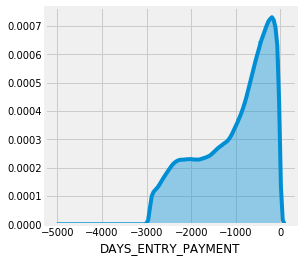

In [65]:
sns.distplot(installments['DAYS_ENTRY_PAYMENT'].dropna())
plt.show()

No problem with day related data

In [283]:
table = installments
var = 'AMT_PAYMENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


In [284]:
table = installments
var = 'DAYS_ENTRY_PAYMENT'
table[var] = table[var].fillna(0)
print('% missing value', table[var].isnull().sum()/len(table[var])* 100)


% missing value 0.0


### Merging with train/test

In [285]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05


In [286]:
installments_by_client.reset_index(inplace=True)

In [287]:
installments_by_client.head()

,SK_ID_CURR,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
1,100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
2,100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
3,100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
4,100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05


In [288]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
print(train.shape, test.shape)

Installments by client shape:  (339587, 102)
(307511, 1312) (48744, 1308)


### Correlation with target

### Memory management

In [289]:
gc.enable()
del installments, installments_by_client
gc.collect()

67

In [302]:
train_col = train.columns
test_col = test.columns

In [311]:
train_col[2]

'CODE_GENDER_XNA'

In [315]:
train_col = train_col.drop('CODE_GENDER_XNA')

In [320]:
train_col[66]

'NAME_FAMILY_STATUS_Unknown'

In [321]:
train_col = train_col.drop('NAME_FAMILY_STATUS_Unknown')

In [325]:
train_col[75]

'NAME_INCOME_TYPE_Maternity leave'

In [326]:
train_col = train_col.drop('NAME_INCOME_TYPE_Maternity leave')

In [328]:
train_col[166]

'TARGET'

In [329]:
train_col = train_col.drop('TARGET')

In [333]:
# checking the excess features in train dataset
train_col = train_col.sort_values()
test_col = test_col.sort_values()
for i in range(len(train_col)):
    if train_col[i]!=test_col[i]:
        print('index', i)        

CODE_GENDER_XNA, NAME_FAMILY_STATUS_Unknown, NAME_INCOME_TYPE_Maternity leave, TARGET are the extra features training set have. Except TARGET, those were created from main categorical feature, CODE_GENDER, NAME_FAMILY_STATUS and NAME_INCOME_TYPE. So we will get rid of those sub-features to align with test table features.

In [334]:
train = train.drop(columns=['CODE_GENDER_XNA', 'NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave'])

In [335]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (307511, 1309)
Final Testing Shape:  (48744, 1308)


In [336]:
train.to_csv('train_final.csv', index = False, chunksize = 500)
test.to_csv('test_final.csv', index = False, chunksize = 500)

## Feature Engineering

In [78]:
# Feature engineering by combining several features to have higher correlation with the target
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET']) # seperating TARGET column from train dataset

#replacing missing values (external sources have missing values)
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.fit_transform(poly_features_test)

# create polynomial object
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree = 3)

# train the polynomial features
poly_transformer.fit(poly_features)

# transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print(poly_features.shape) # we started with 4 variables as poly features and ended with 35
columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])
print(columns[:10]) # new feature names

(307511, 35)
['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH', 'EXT_SOURCE_2^2']


We started with 4 features and after transformation we have 35 features which are all possible combination between polynomial features, such as EXT_SOURCE_1^2, EXT_SOURCE_1 EXT_SOURCE_2, EXT_SOURCE_1 EXT_SOURCE_3 etc.

In [79]:
# checking correlation with target
# creating dataframe with new features in train dataset
poly_features = pd.DataFrame(poly_features, columns = columns)
poly_features['TARGET'] = poly_target

# find correlation in train
poly_corrs = poly_features.corr()['TARGET'].sort_values()
print(poly_corrs.head(10), '\n', poly_corrs.tail(10))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64 
 EXT_SOURCE_1 DAYS_BIRTH                 0.104882
EXT_SOURCE_3^2 DAYS_BIRTH               0.141777
EXT_SOURCE_2^2 DAYS_BIRTH               0.149313
EXT_SOURCE_3 DAYS_BIRTH                 0.150109
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH    0.151816
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                 

The correlations have improved than earlier. There are several features which are important to understand the financial capacity of a cliet, such as the percentage of the credit amount relative to a client's income (CREDIT_INCOME_PERCENT), the percentage of the loan annuity relative to a client's income (ANNUITY_INCOME_PERCENT), the length of the payment in months (since the annuity is the monthly amount due (CREDIT_TERM), the percentage of the days employed relative to the client's age (DAYS_EMPLOYED_PERCENT) etc. 

In [85]:
train_domain = train.copy()
train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL']
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']
domain = pd.concat([train_domain['CREDIT_INCOME_PERCENT'], train_domain['ANNUITY_INCOME_PERCENT'], train_domain['CREDIT_TERM'], train_domain['DAYS_EMPLOYED_PERCENT'], train_domain['TARGET']], axis=1)
test_domain = test.copy()
test_domain['CREDIT_INCOME_PERCENT'] = test_domain['AMT_CREDIT'] / test_domain['AMT_INCOME_TOTAL']
test_domain['ANNUITY_INCOME_PERCENT'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_INCOME_TOTAL']
test_domain['CREDIT_TERM'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_CREDIT']
test_domain['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED'] / test_domain['DAYS_BIRTH']
domain_corrs = domain.corr()['TARGET'].sort_values()
print(domain_corrs)

CREDIT_INCOME_PERCENT    -0.007727
CREDIT_TERM               0.012704
ANNUITY_INCOME_PERCENT    0.014265
DAYS_EMPLOYED_PERCENT     0.042206
TARGET                    1.000000
Name: TARGET, dtype: float64


In [74]:
## geting rid of excess columns in train dataset
train_labels = train['TARGET']
train, test = train.align(test, join = 'inner', axis=1)
train['TARGET'] = train_labels
print(train.shape, test.shape)

(307511, 240) (48744, 239)


## Save All Newly Calculated Features

In [ ]:
train.to_csv('train_final.csv', index = False, chunksize = 500)
test.to_csv('test_final.csv', index = False)